In [68]:
## 0.0 IMPORTS
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso

In [3]:
#0.1 Helper functions

def ml_error (model_name,y,yhat):
    
    mae = mean_absolute_error (y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error (y, yhat))

    return pd.DataFrame({ 'Model Name' : model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    


In [4]:
## 0.1.1 Loading data

df_store_raw  = pd.read_csv('data/store.csv', low_memory=False)
df_sales_raw  = pd.read_csv('data/train.csv', low_memory=False)

## merge

df_raw = pd.merge(df_sales_raw,df_store_raw, how='left',on='Store')

In [5]:
## 1.0 Descrição dos dados

df1 = df_raw.copy()



In [6]:
## 1.1 Rename columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase,cols_old))

df1.columns = new_cols

df1.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
## 1.2 Data Dimensions

print('Number of rows : {}'.format(df1.shape[0]))
print('Number of cols : {}'.format(df1.shape[1]))

Number of rows : 1017209
Number of cols : 18


In [8]:
## Data Types

df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
## 1.4 Check NA

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
## 1.5 Fillout NA

#competition_distance  

df1['competition_distance'] = np.where(df1['competition_distance'].isna(),200000.0,df1['competition_distance'])

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year  

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2                       
#promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval               

month_map = {1: 'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}


df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1.apply(lambda x: 1 if (x['promo_interval'] != 0) and (x['month_map'] in x['promo_interval'].split(',')) else 0, axis=1)

In [12]:
## 1.6 Change Types

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [13]:
## 1.7 Descriptive Statistical

num_attributes = df1.select_dtypes(include = ['int32','int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32','int64','float64','datetime64[ns]'])


In [14]:
## 1.7.1 Numerical Attributes

#Central Tendency - mean ,  median

ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T


#Dispersion - std,min,max,range,skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() -x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = (['attributes','min','max','range','media','median','std','skew','kurtosis'])

In [15]:
m

,attributes,min,max,range,media,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [16]:
## 1.7.1 Categorical Attributes


cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

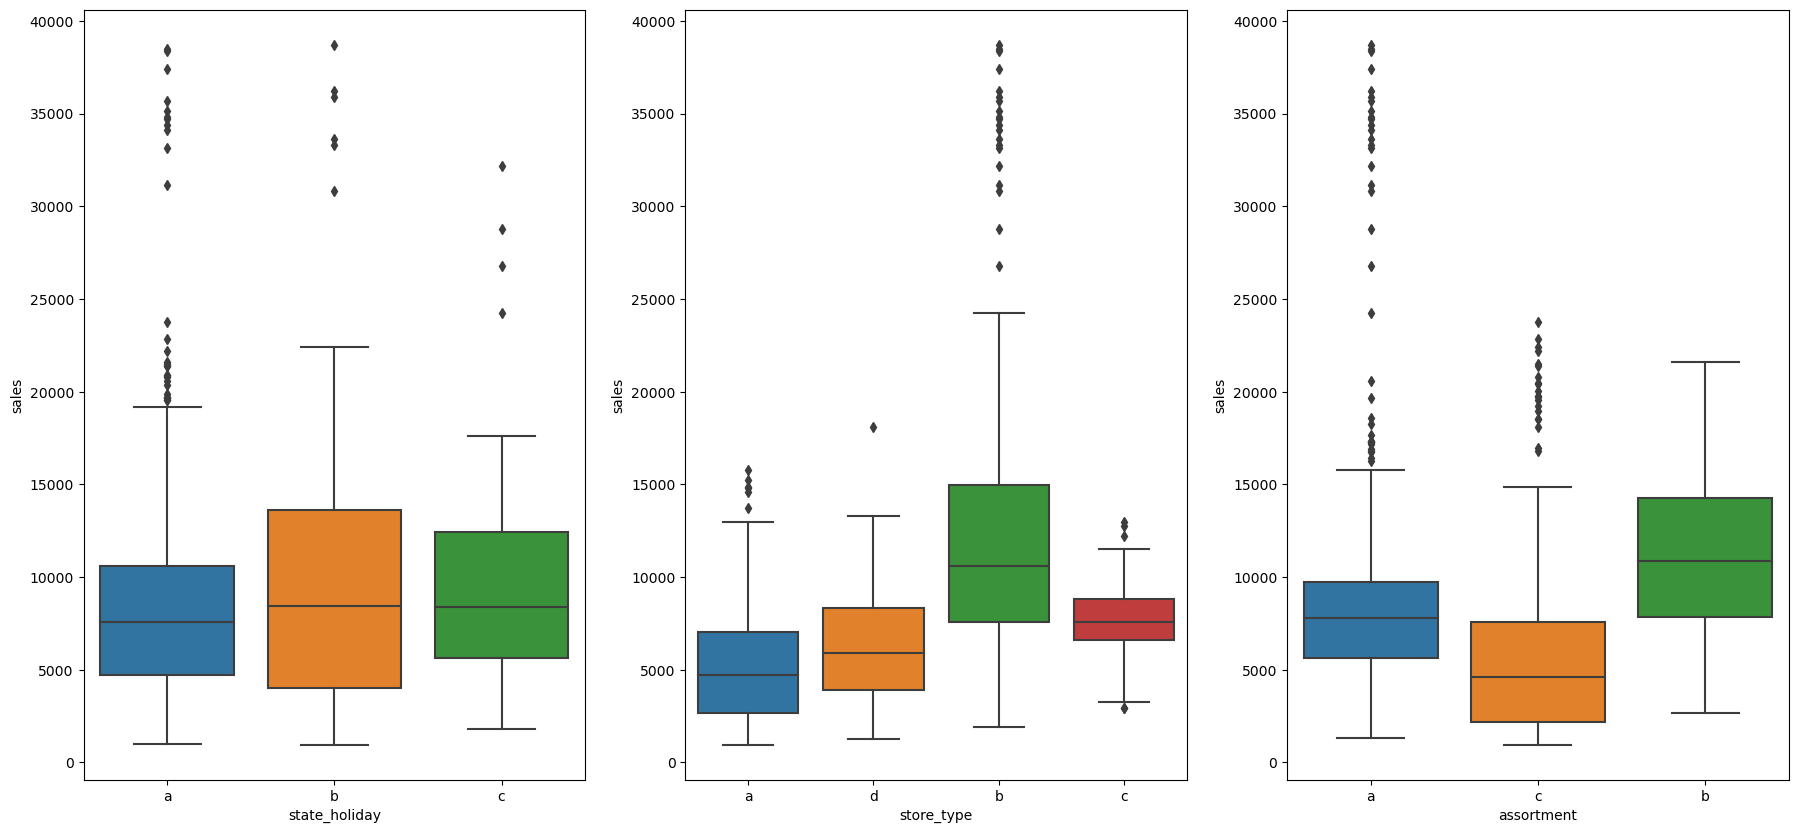

In [17]:
#condições
aux1 = df1[ ((df1['state_holiday']) != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(22, 10))


plt.subplot (1,3,1)
sns.boxplot( x='state_holiday' ,y= 'sales' ,data = aux1 )

plt.subplot (1,3,2)
sns.boxplot( x='store_type' ,y= 'sales' ,data = aux1 )

plt.subplot (1,3,3)
sns.boxplot( x='assortment' ,y= 'sales' ,data = aux1 )

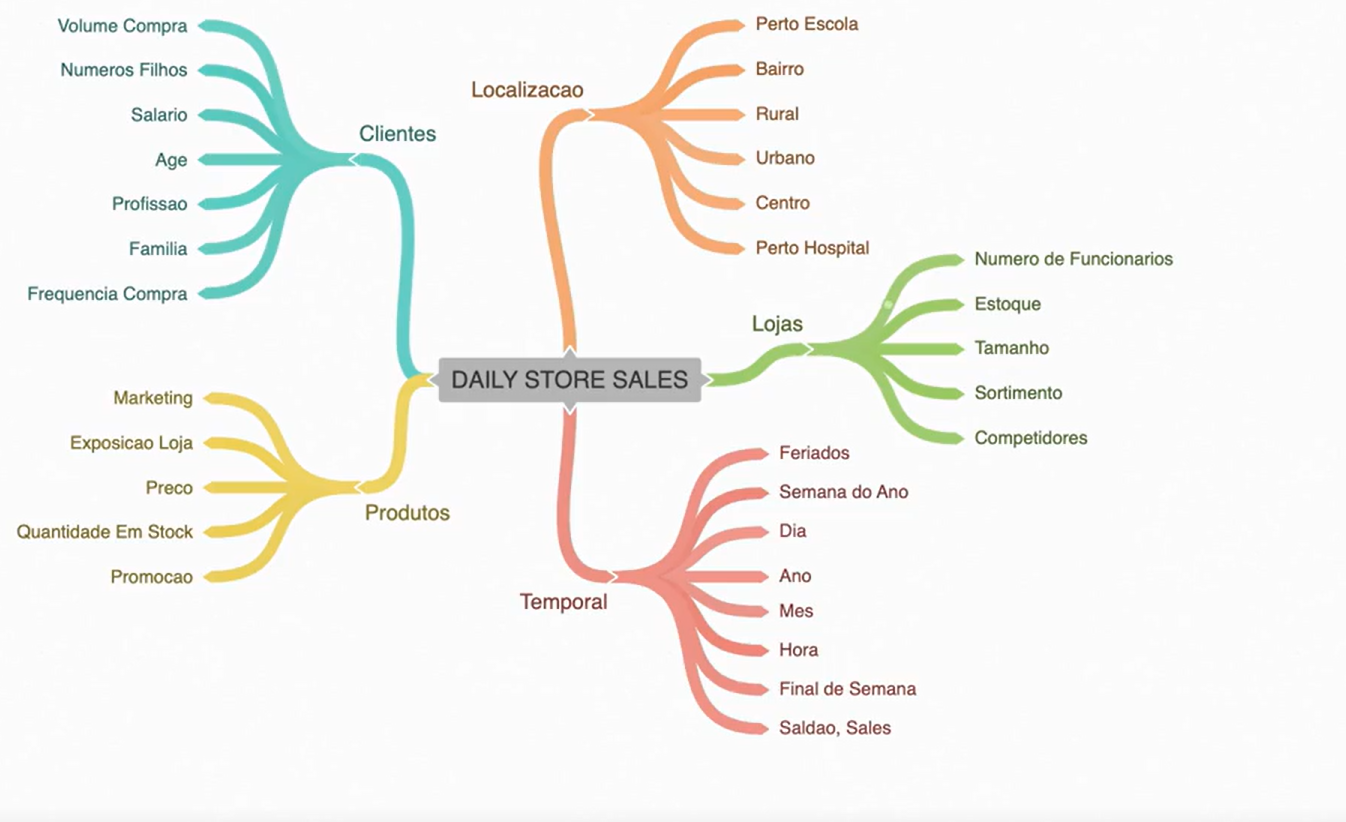

In [18]:
## 2.0 Passo 02 - Feature Engineering

Image('img/Mapa_Mental_hipoteses.png')

In [19]:
#2.1. Criacao das Hipoteses

#2.1.1. Hipoteses Loja

#1. Lojas com número maior de funcionários deveriam vender mais.
#2. Lojas com maior capacidade de estoque deveriam vender mais.
#3. Lojas com maior porte deveriam vender mais.
#4. Lojas com maior sortimentos deveriam vender mais.
#5. Lojas com competidores mais próximos deveriam vender menos.
#6. Lojas com competidores à mais tempo deveriam vendem mais.


#2.1 2. Hipoteses Produto

#1. Lojas que investem mais em Marketing deveriam vender mais.
#2. Lojas com maior exposição de produto deveriam vender mais.
#3. Lojas com produtos com preço menor deveriam vender mais.
#5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
#6. Lojas com promoções ativas por mais tempo deveriam vender mais.
#7. Lojas com mais dias de promoção deveriam vender mais.
#8. Lojas com mais promoções consecutivas deveriam vender mais.

#2.1.3. Hipoteses Tempo

#1. Lojas abertas durante o feriado de Natal deveriam vender mais.
#2. Lojas deveriam vender mais ao longo dos anos.
#3. Lojas deveriam vender mais no segundo semestre do ano.
#4. Lojas deveriam vender mais depois do dia 10 de cada mês.
#5. Lojas deveriam vender menos aos finais de semana.
#6. Lojas deveriam vender menos durante os feriados escolares.



In [20]:
#2.2 Lista Final de Hipóteses

#1. Lojas com maior sortimentos deveriam vender mais.
#2. Lojas com competidores mais próximos deveriam vender menos.
#3. Lojas com competidores à mais tempo deveriam vendem mais.
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#5. Lojas com mais dias de promoção deveriam vender mais.
#7. Lojas com mais promoções consecutivas deveriam vender mais.
#8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#9. Lojas deveriam vender mais ao longo dos anos.
#10. Lojas deveriam vender mais no segundo semestre do ano.
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#12. Lojas deveriam vender menos aos finais de semana.
#13. Lojas deveriam vender menos durante os feriados escolares.

In [21]:
#2.3 Feature Engineering
df2 = df1.copy()

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( "%Y-%W")

#competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'],month = x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) /30).apply(lambda x : x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+ '-1', '%Y-%W-%w')- datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']- df2['promo_since']) /7 ).apply(lambda x: x.days).astype(int)


#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extendend')


#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x== 'c' else 'regular_day')


C:\Users\lucas\AppData\Local\Temp\ipykernel_2412\1600005653.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [22]:
## 3.0 Passo 3 - FILTRAGEM DE VARIÁVEIS

df3 = df2.copy()

In [23]:
## 3.1  - FILTRAGEM DAS LINHAS


df3 = df3[(df3['open'] != 0) & (df3['sales'] > 1)]

In [24]:
## 3.1  - SELECAO DAS COLUNAS

cols_drop =  ['customers', 'open','month_map' ,'promo_interval']

df3 = df3.drop(cols_drop, axis=1)

In [25]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [26]:
#copia df

df4 = df3.copy()

In [27]:
# 4.0  PASSO 04 - ANÁLSE EXPLORATÓRIA DOS DADOS

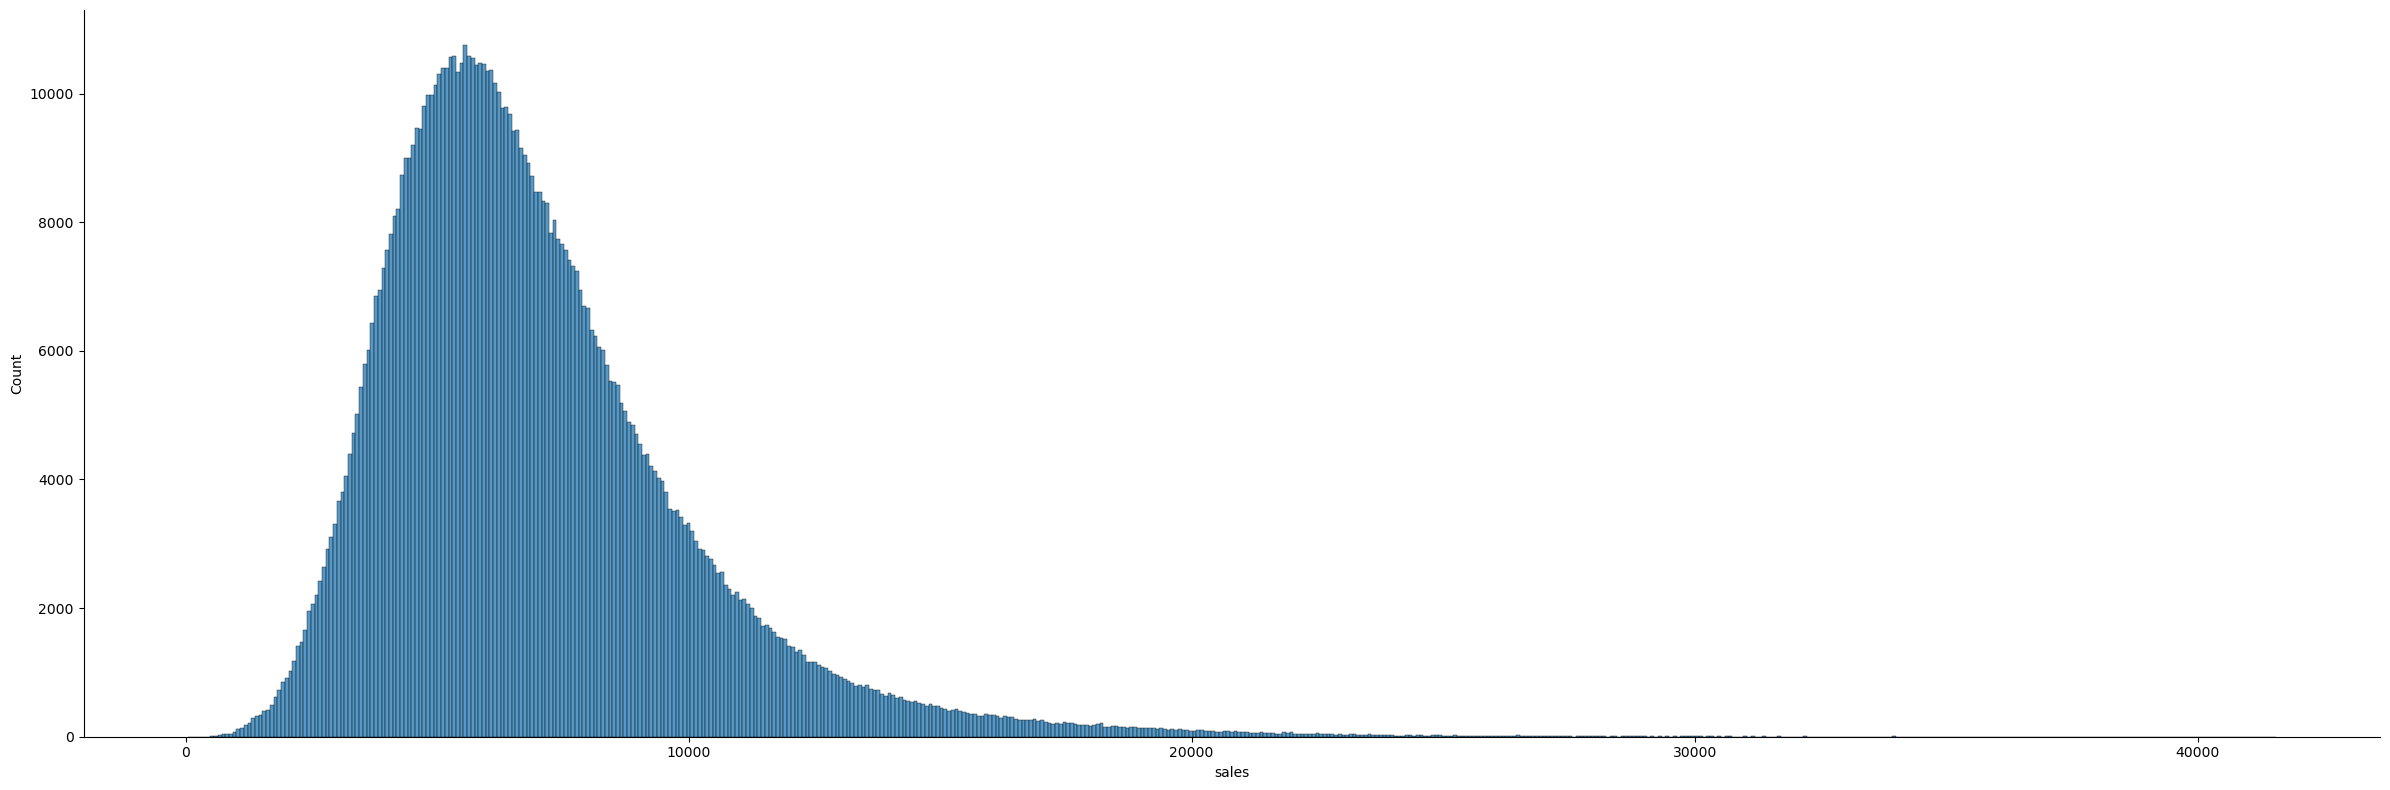

In [28]:
# 4.1 ANÁLISE UNIVARIADA


# 4.1.1 Response Variable

sns.displot(df4['sales'], height=8, aspect=3,kde = False)


array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

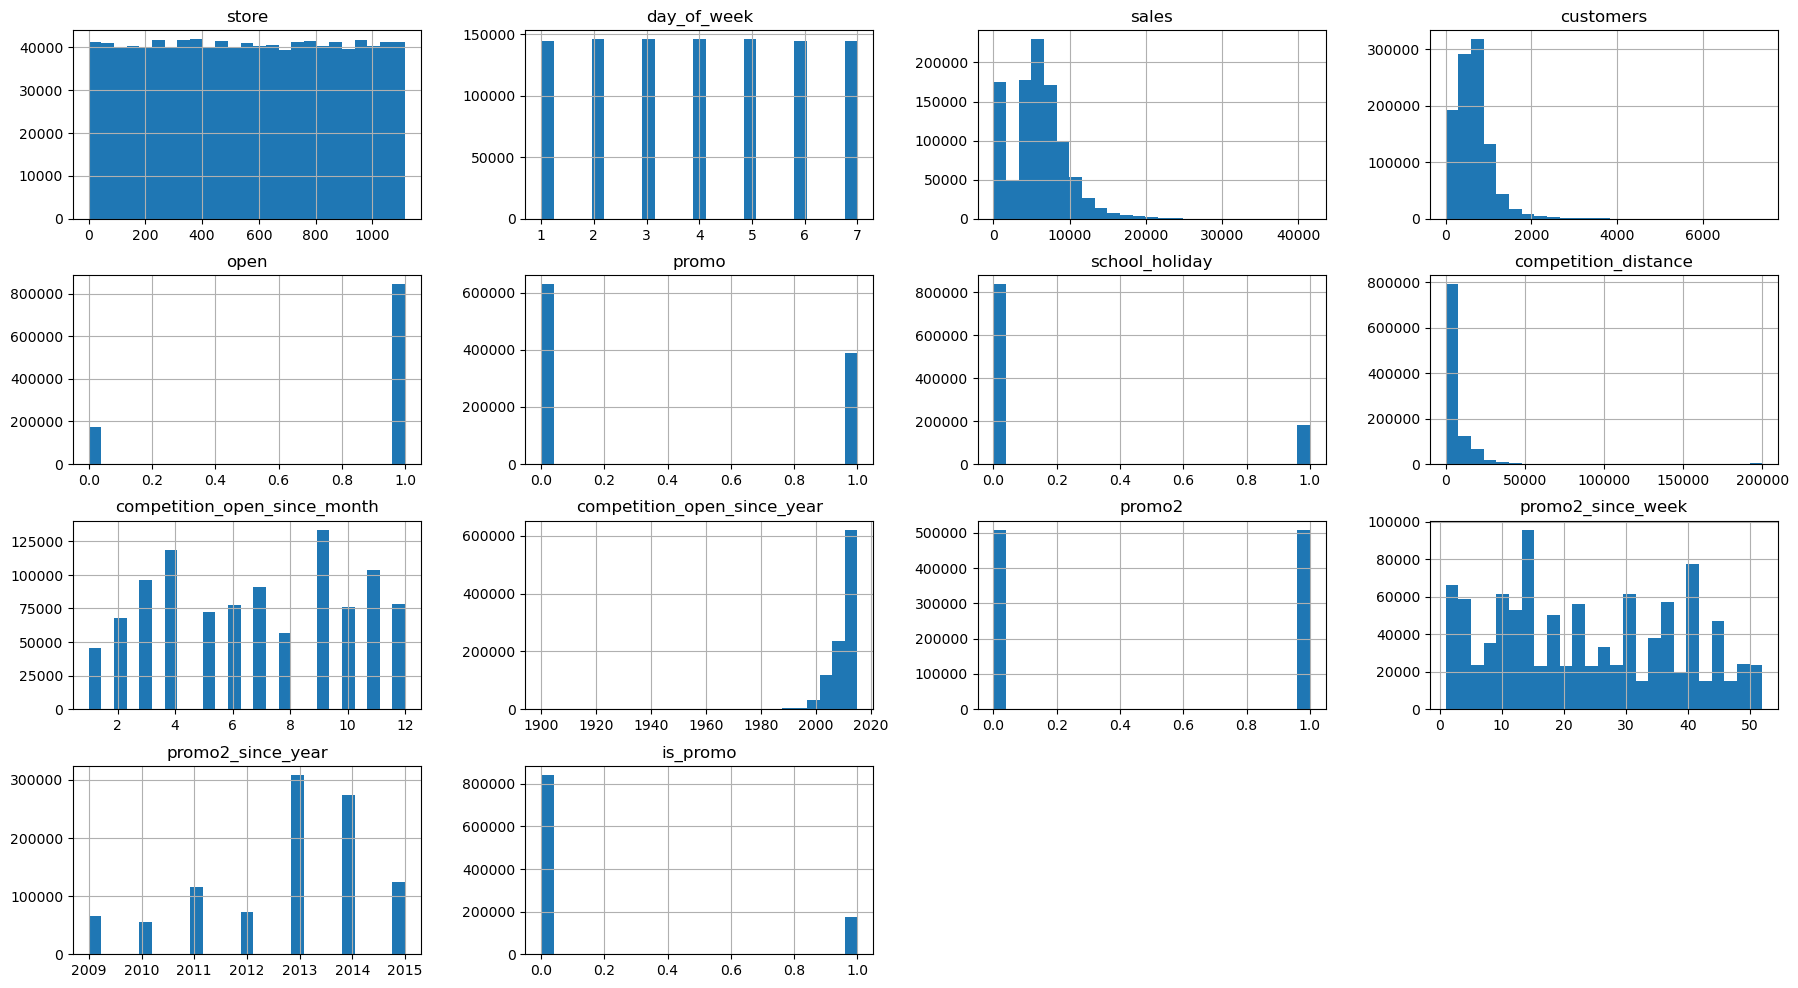

In [29]:
# 4.1.2 Numerical Variable

num_attributes.hist( bins = 25,figsize=(22, 12))

In [30]:
# 4.1.3 Categorical Variable

df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\lucas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

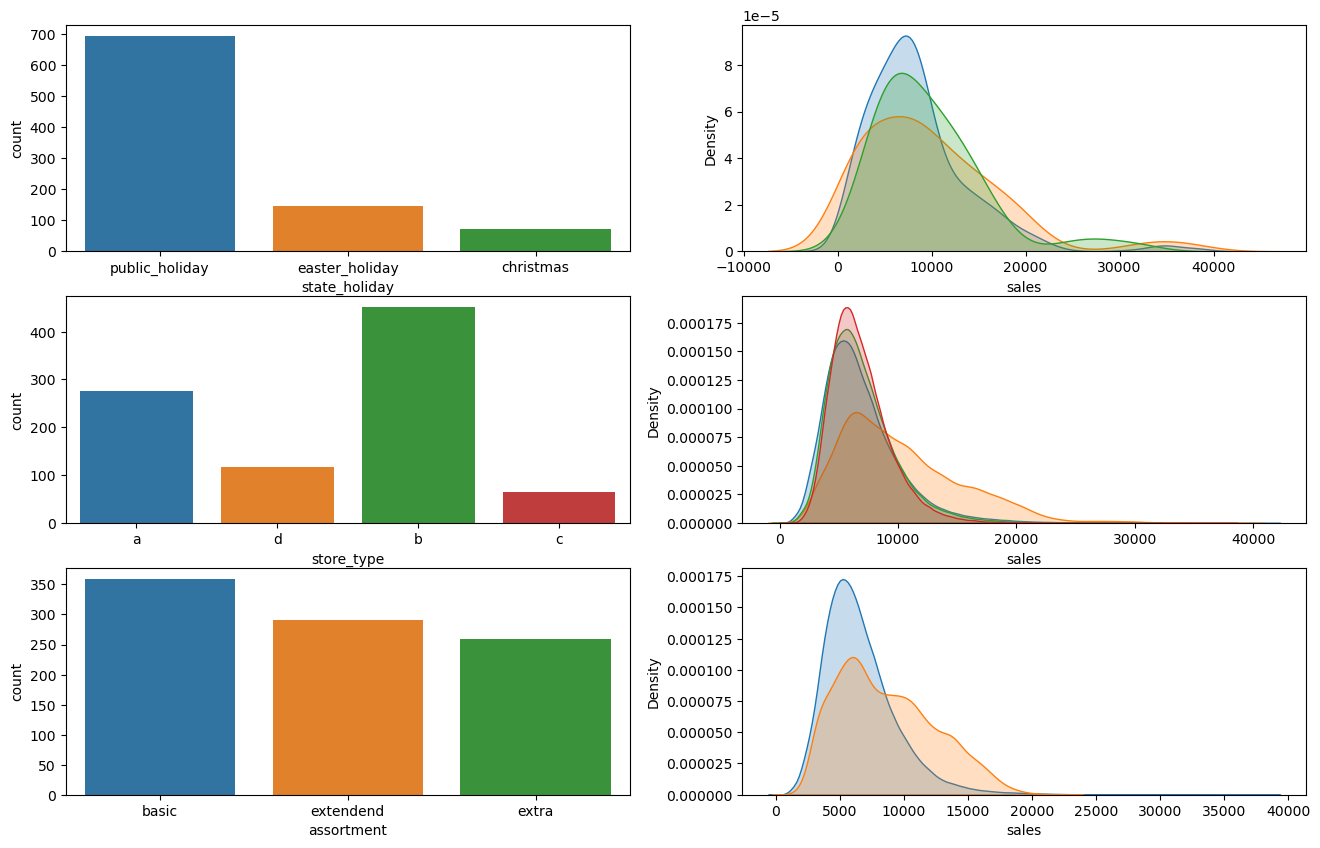

In [31]:
# state_holiday

plt.figure(figsize=(16, 10))


plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)

# Store_type

plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',shade=True)

# Assortment


plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra',shade=True)


<AxesSubplot:xlabel='year_week'>

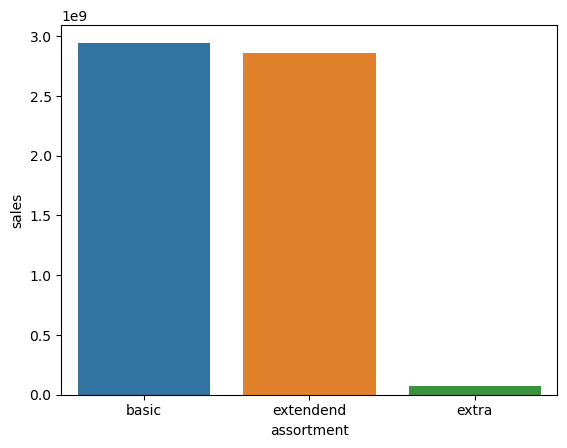

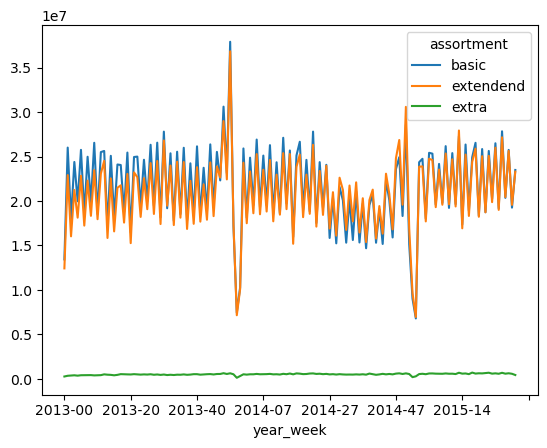

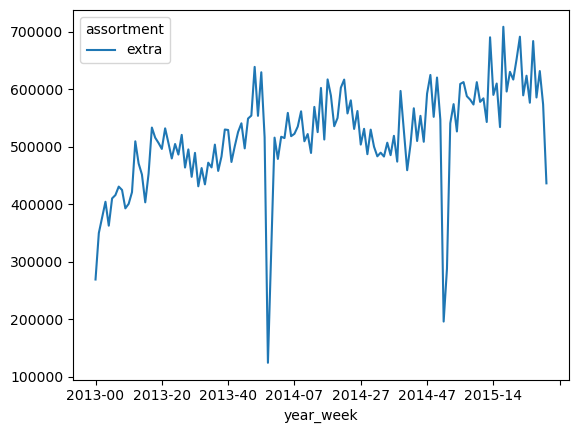

In [32]:
# 4.2 ANÁLISE BIVARIADA
#1. Lojas com maior sortimentos deveriam vender mais.
### Lojas com maior sortimento vendem menos.

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment',y='sales', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment']== 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()


C:\Users\lucas\AppData\Local\Temp\ipykernel_2412\2902332728.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'),annot= True)


<AxesSubplot:>

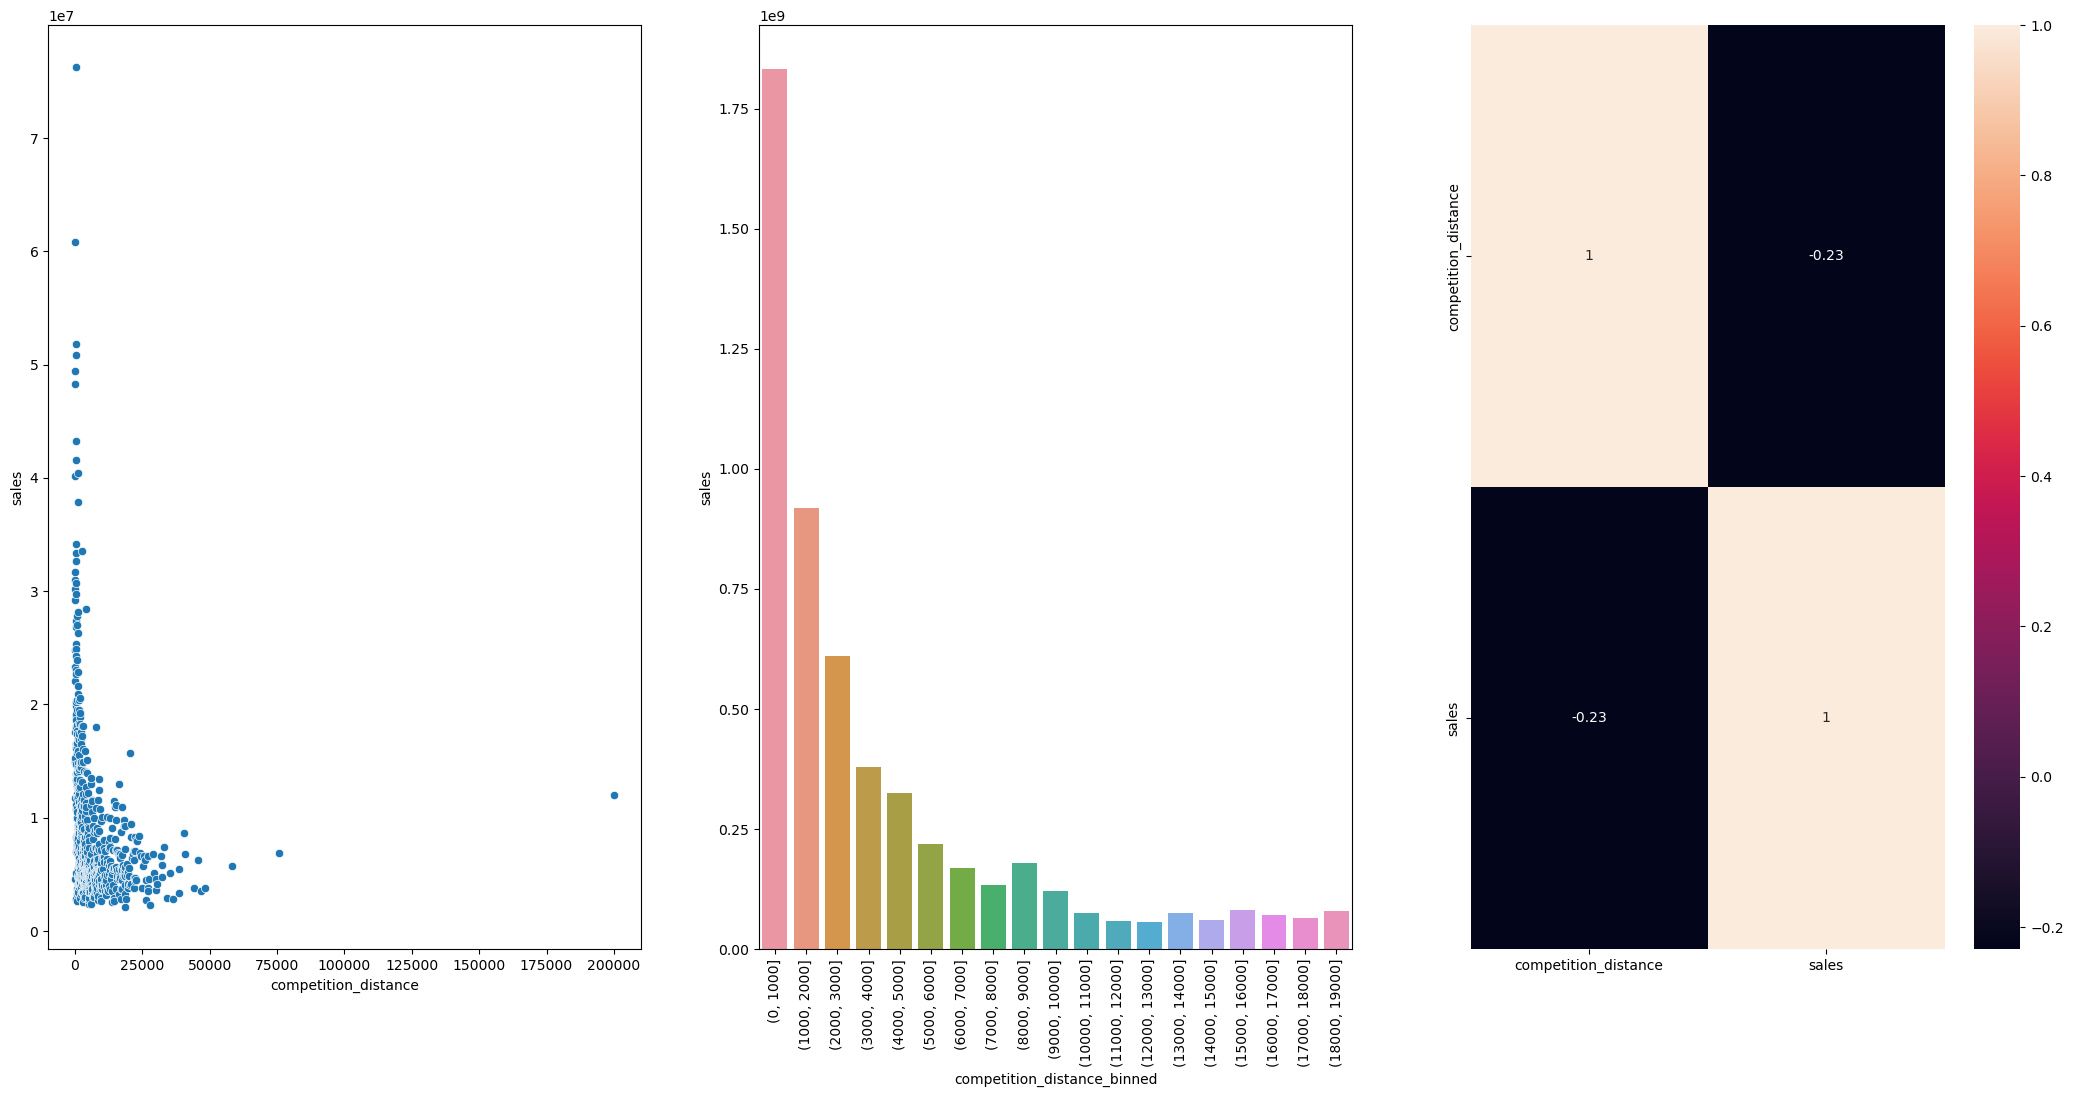

In [33]:
# 4.2.1 ANÁLISE BIVARIADA
#H2. Lojas com competidores mais próximos deveriam vender menos.

plt.figure(figsize=(26, 12))
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)

sns.heatmap(aux1.corr(method='pearson'),annot= True)


<AxesSubplot:>

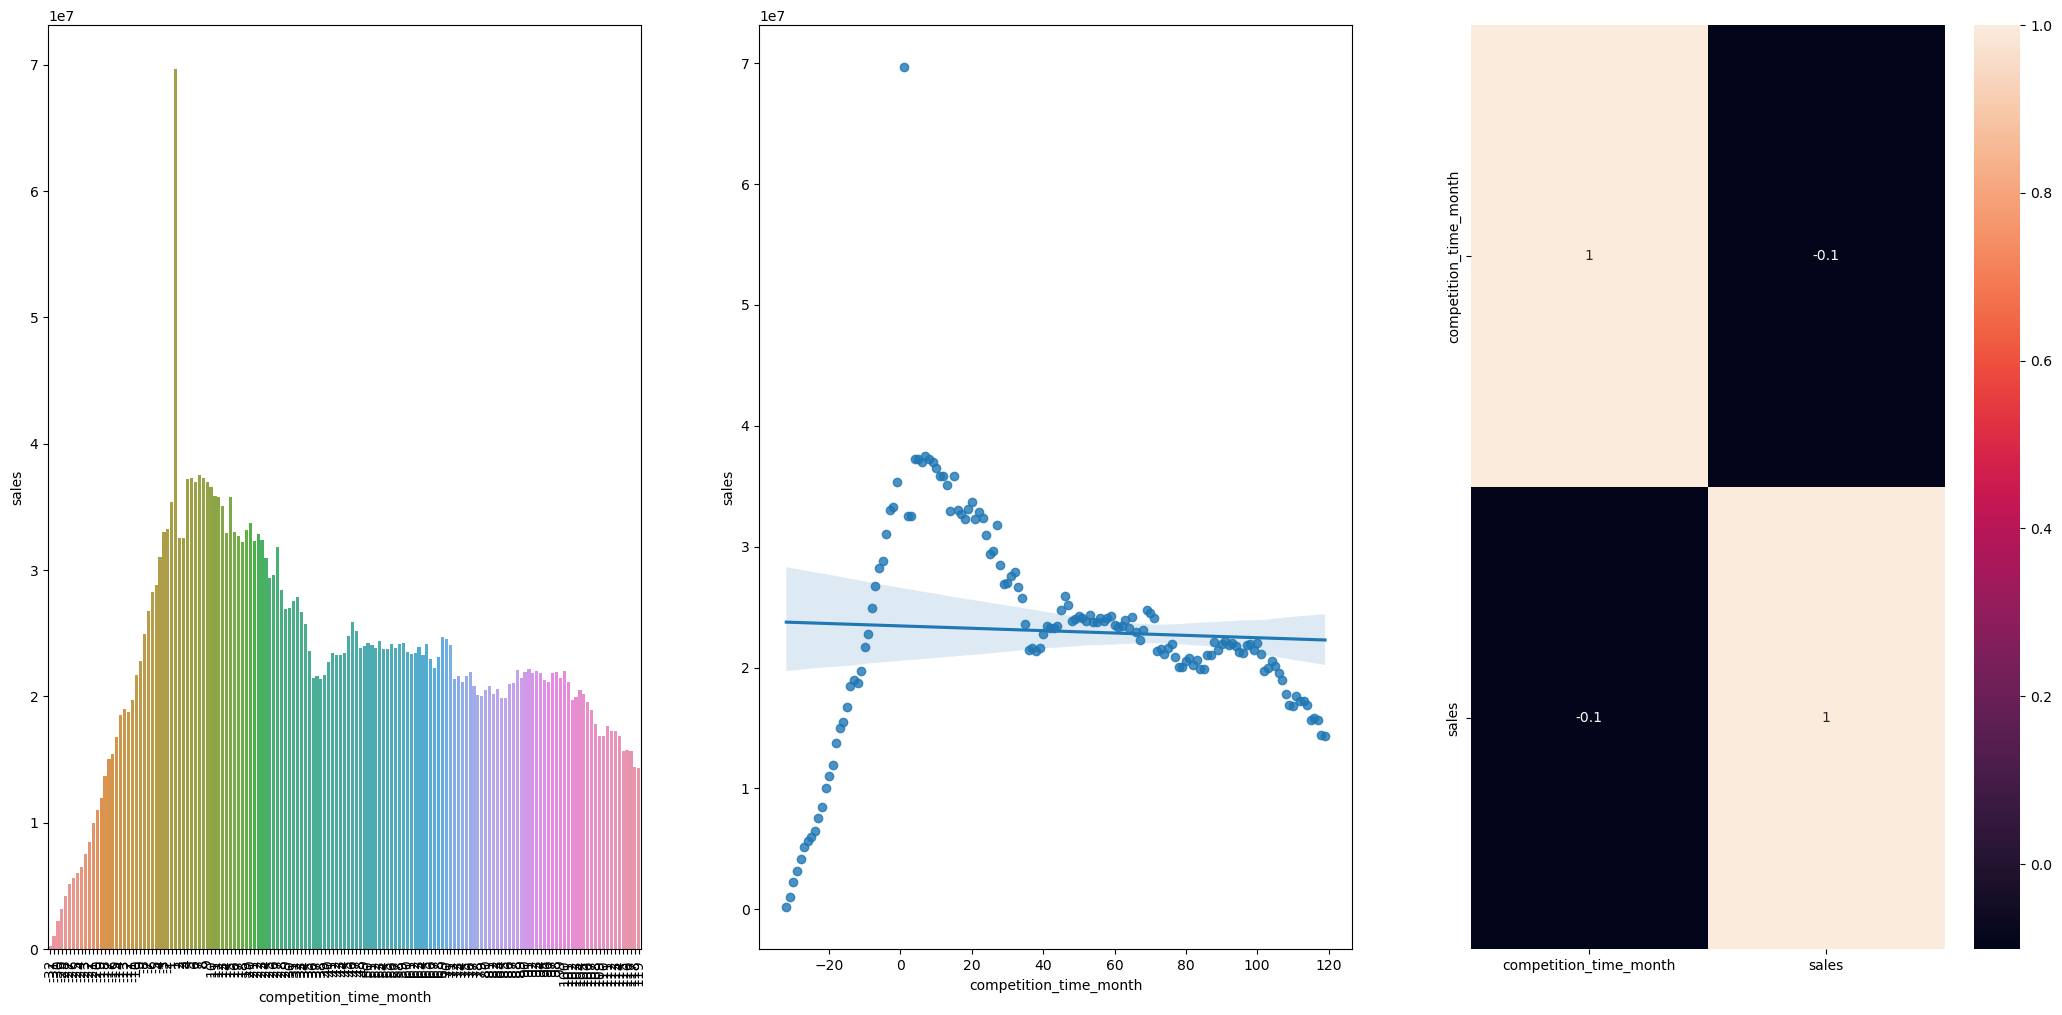

In [34]:
# 4.2.3 ANÁLISE BIVARIADA
# H3. Lojas com competidores à mais tempo deveriam vendem mais

plt.figure(figsize=(26, 12))

plt.subplot(1,3,1)
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month']!=0)]
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales',data= aux2 );

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


<AxesSubplot:>

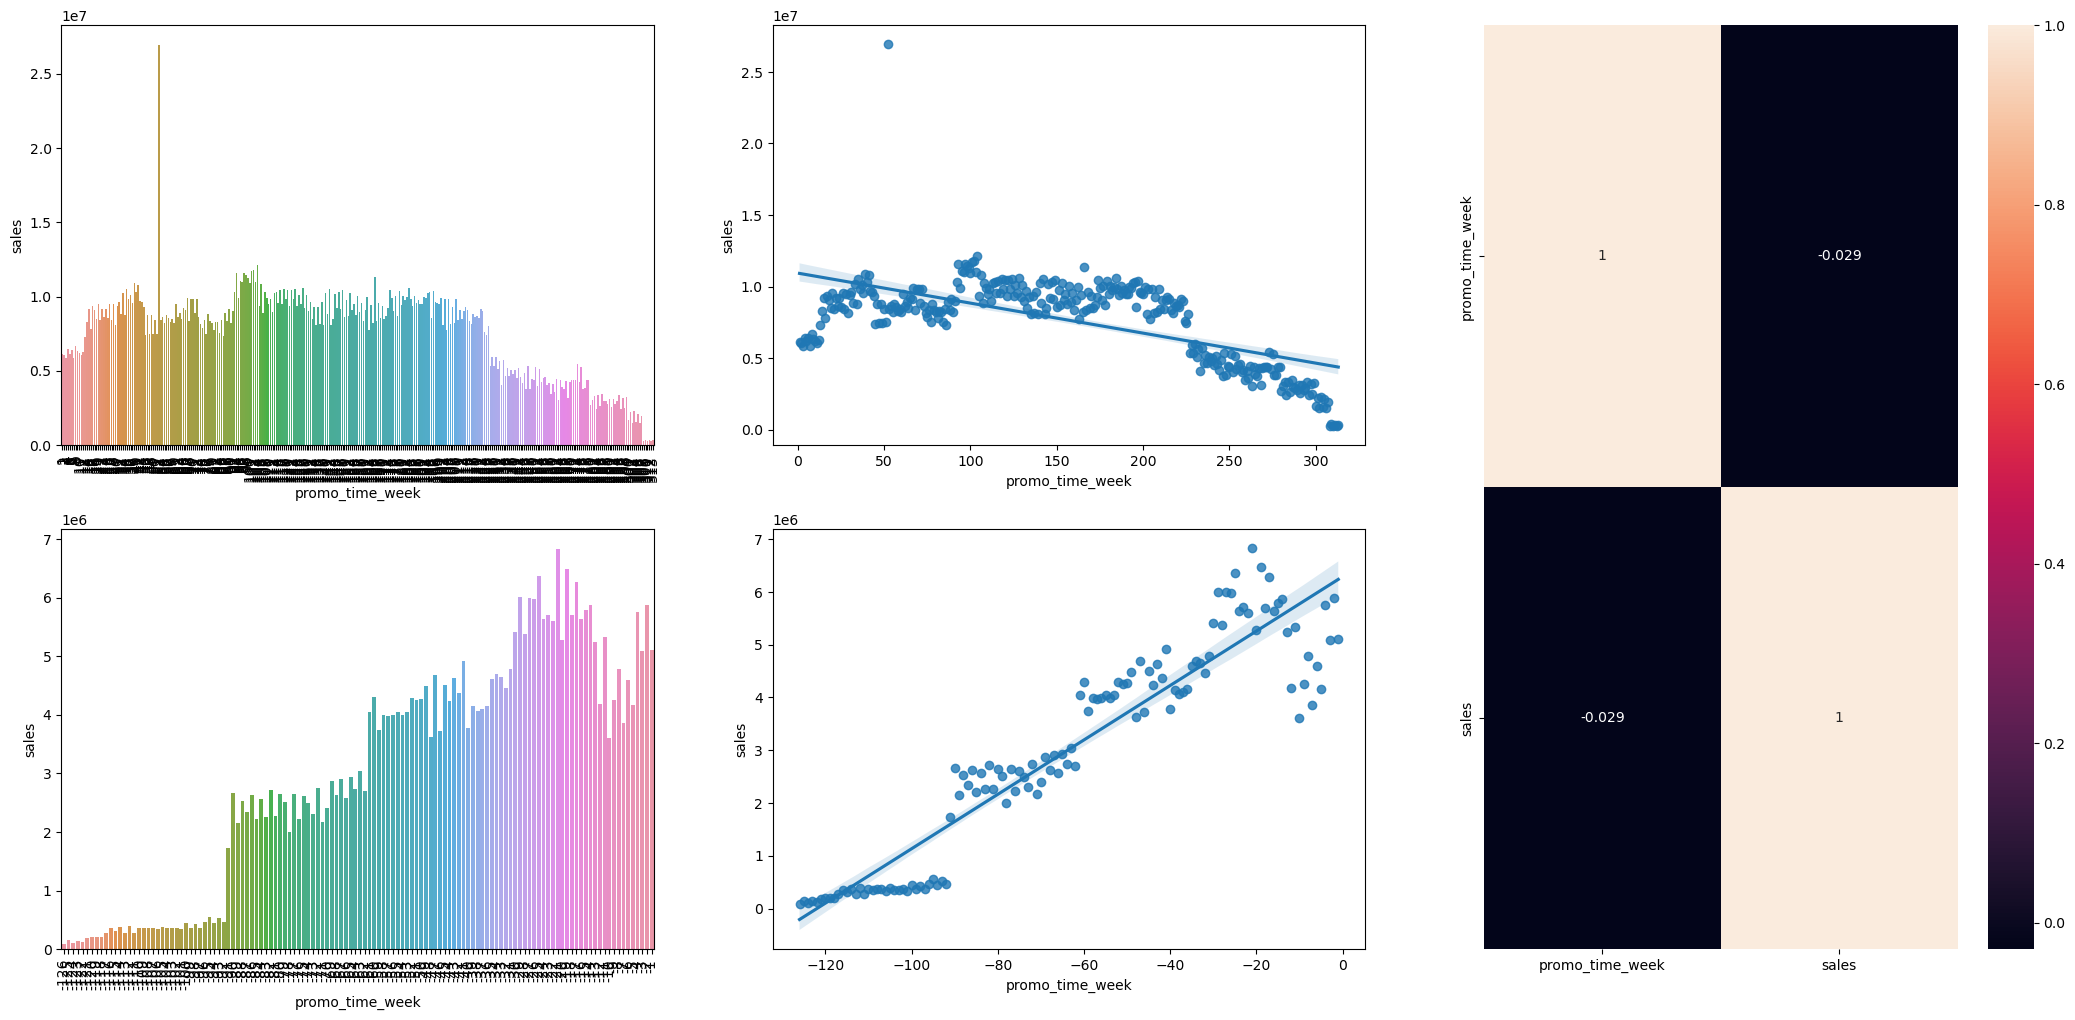

In [35]:
# 4.2.3 ANÁLISE BIVARIADA
#H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
# falsa, lojas com promoção ativa por mais tempo vendem menos após um certo período de tempo

plt.figure(figsize=(26, 12))

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week',y='sales',data= aux2)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2) # regplot - tendencia

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo normal
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week',y='sales',data= aux3)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3) # regplot - tendencia

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)# heatmap - correlação


In [36]:
# 4.2.3 ANÁLISE BIVARIADA
# H5. Lojas com mais dias de promoção deveriam vender mais.


<Figure size 2600x1200 with 0 Axes>

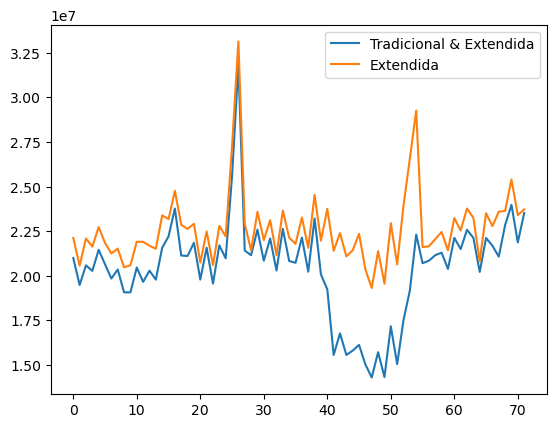

In [37]:
# 4.2.3 ANÁLISE BIVARIADA
#H7. Lojas com mais promoções consecutivas deveriam vender mais.
# falsa, lojas com promoções consecultivas vendem menos


plt.figure(figsize=(26, 12))

df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

aux2= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida','Extendida'])

<AxesSubplot:xlabel='year', ylabel='sales'>

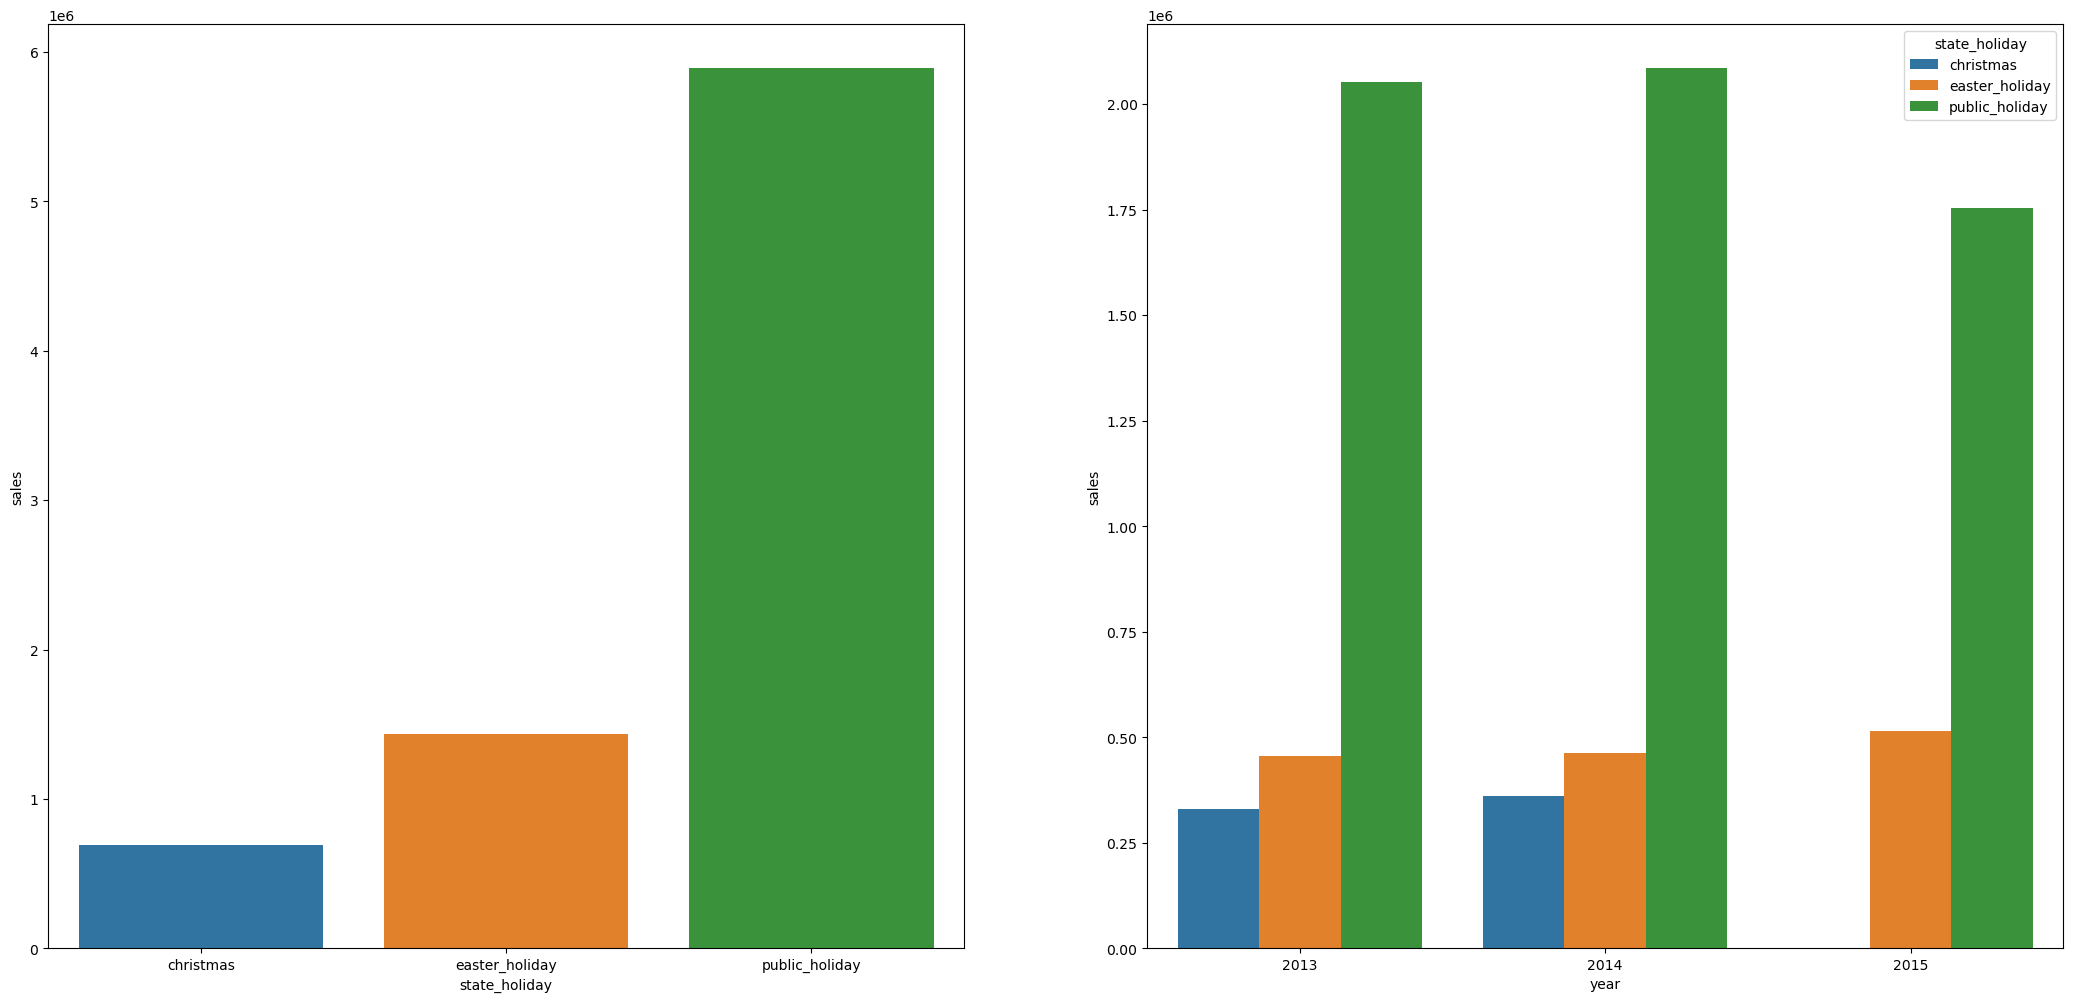

In [38]:
# 4.2.3 ANÁLISE BIVARIADA
# h8. Lojas abertas durante o feriado de Natal deveriam vender mais.
# falsa, lojas abertas durante o natal vendem menos

plt.figure(figsize=(26, 12))
aux = df4[df4['state_holiday']!= 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
df4['state_holiday']!= 'regular_day'
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday' ,data= aux2)

<AxesSubplot:>

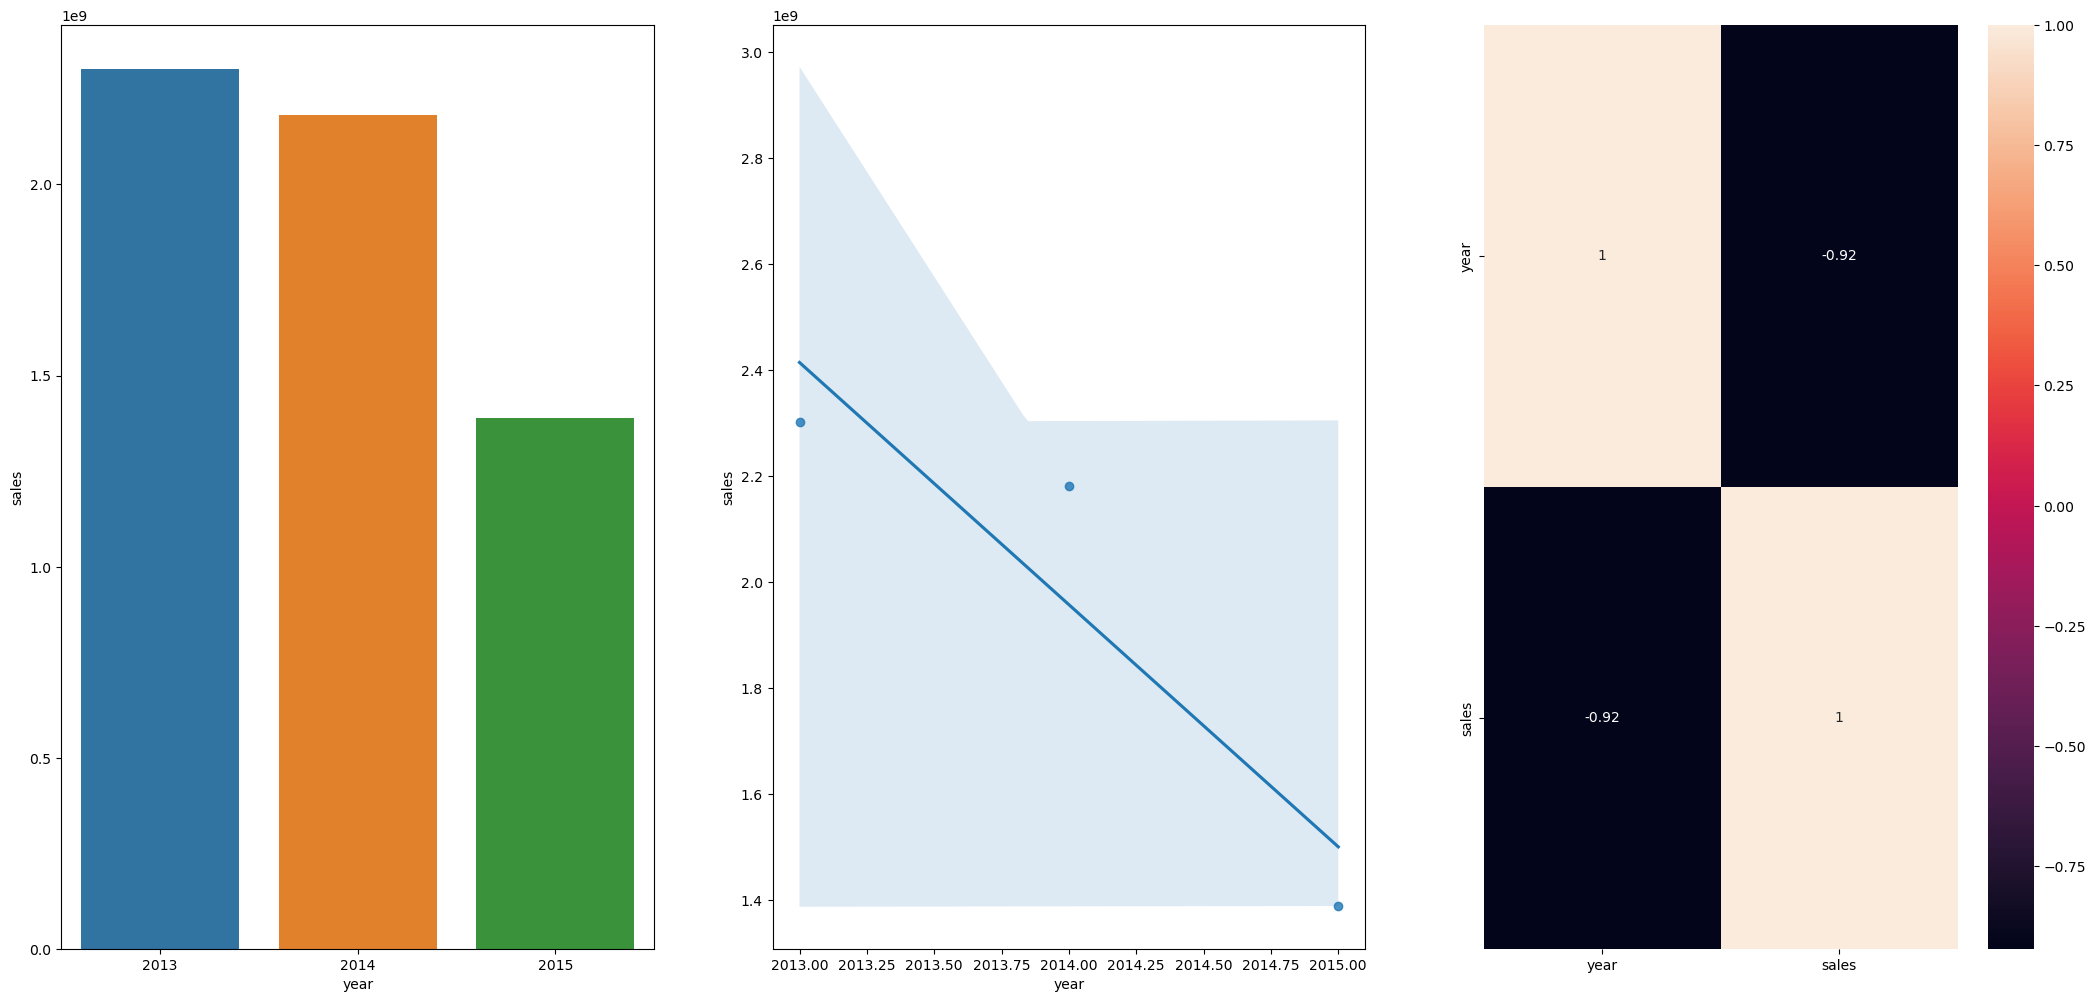

In [39]:
# 4.2.3 ANÁLISE BIVARIADA
# h9. Lojas deveriam vender mais ao longo dos anos.
# FALSA, AS LOJAS VENDEM MENOS AO LONGO DOS ANOS

plt.figure(figsize=(26, 12))
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1) # regplot - tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True) # heatmap - correlação

<AxesSubplot:>

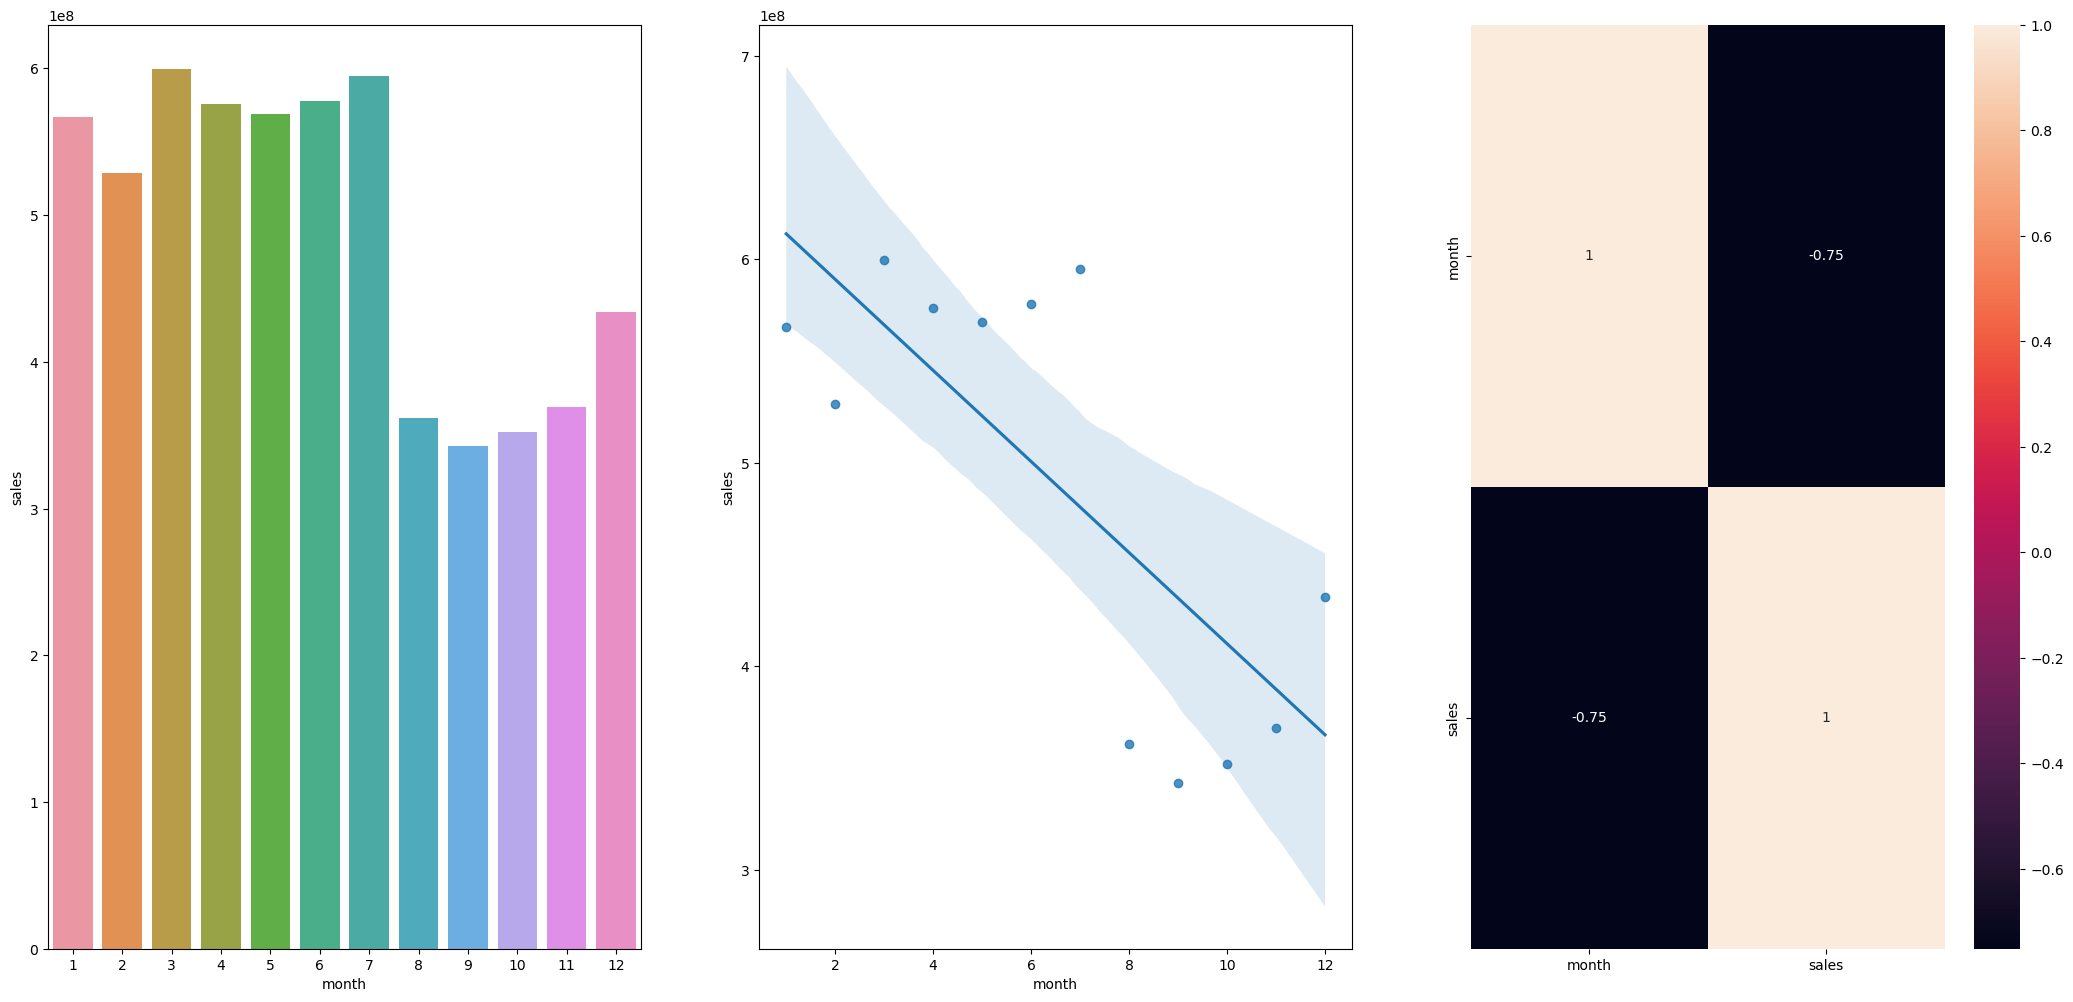

In [40]:
# 4.2.3 ANÁLISE BIVARIADA
# h10. Lojas deveriam vender mais no segundo semestre do ano.
# falsa , as lojas vendem mais no primeiro semestre do ano

plt.figure(figsize=(26, 12))
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1) # regplot - tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True) # heatmap - correlação


<AxesSubplot:xlabel='before_after', ylabel='sales'>

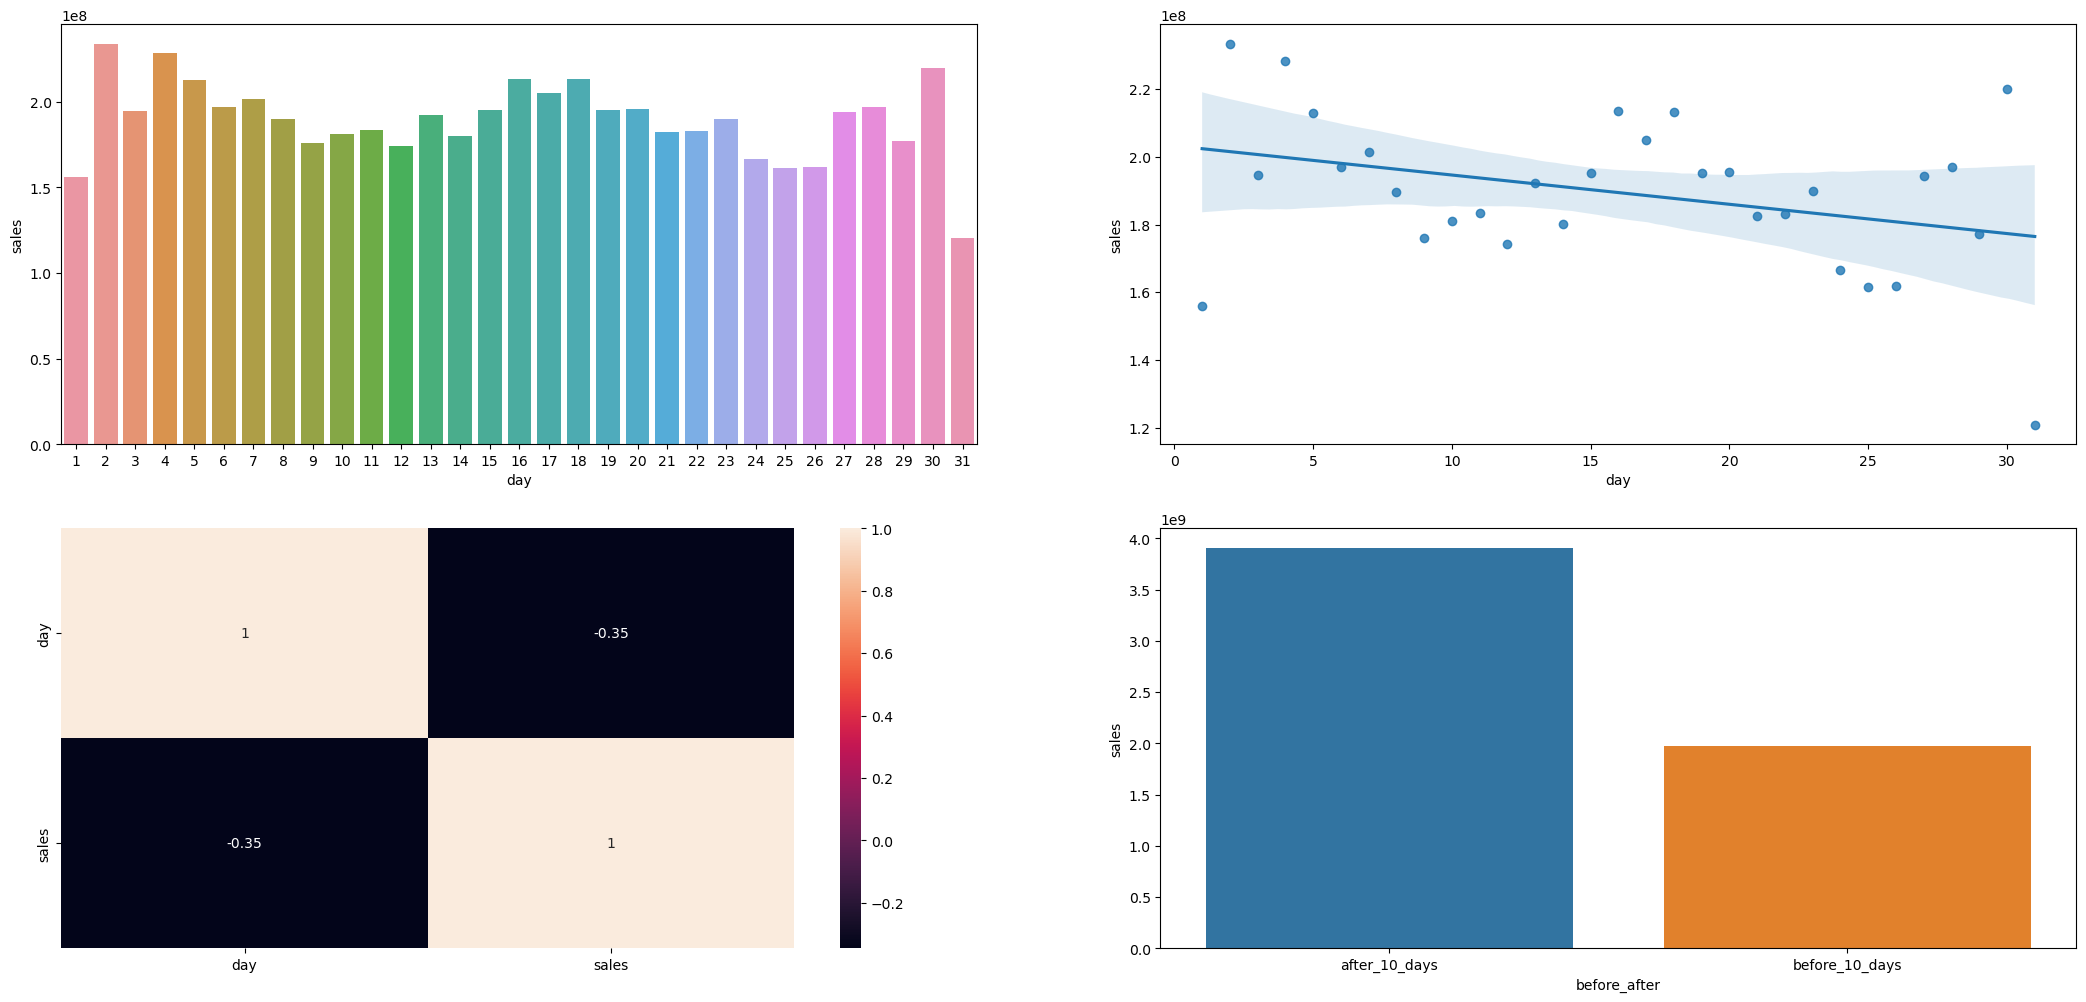

In [41]:
# 4.2.3 ANÁLISE BIVARIADA
# h11. Lojas deveriam vender mais depois do dia 10 de cada mês.
# Verdadeira, depois do dia 10 as lojas vendem mais

plt.figure(figsize=(26, 12))
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1) # regplot - tendencia

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True) # heatmap - correlação


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4)
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2)


<AxesSubplot:>

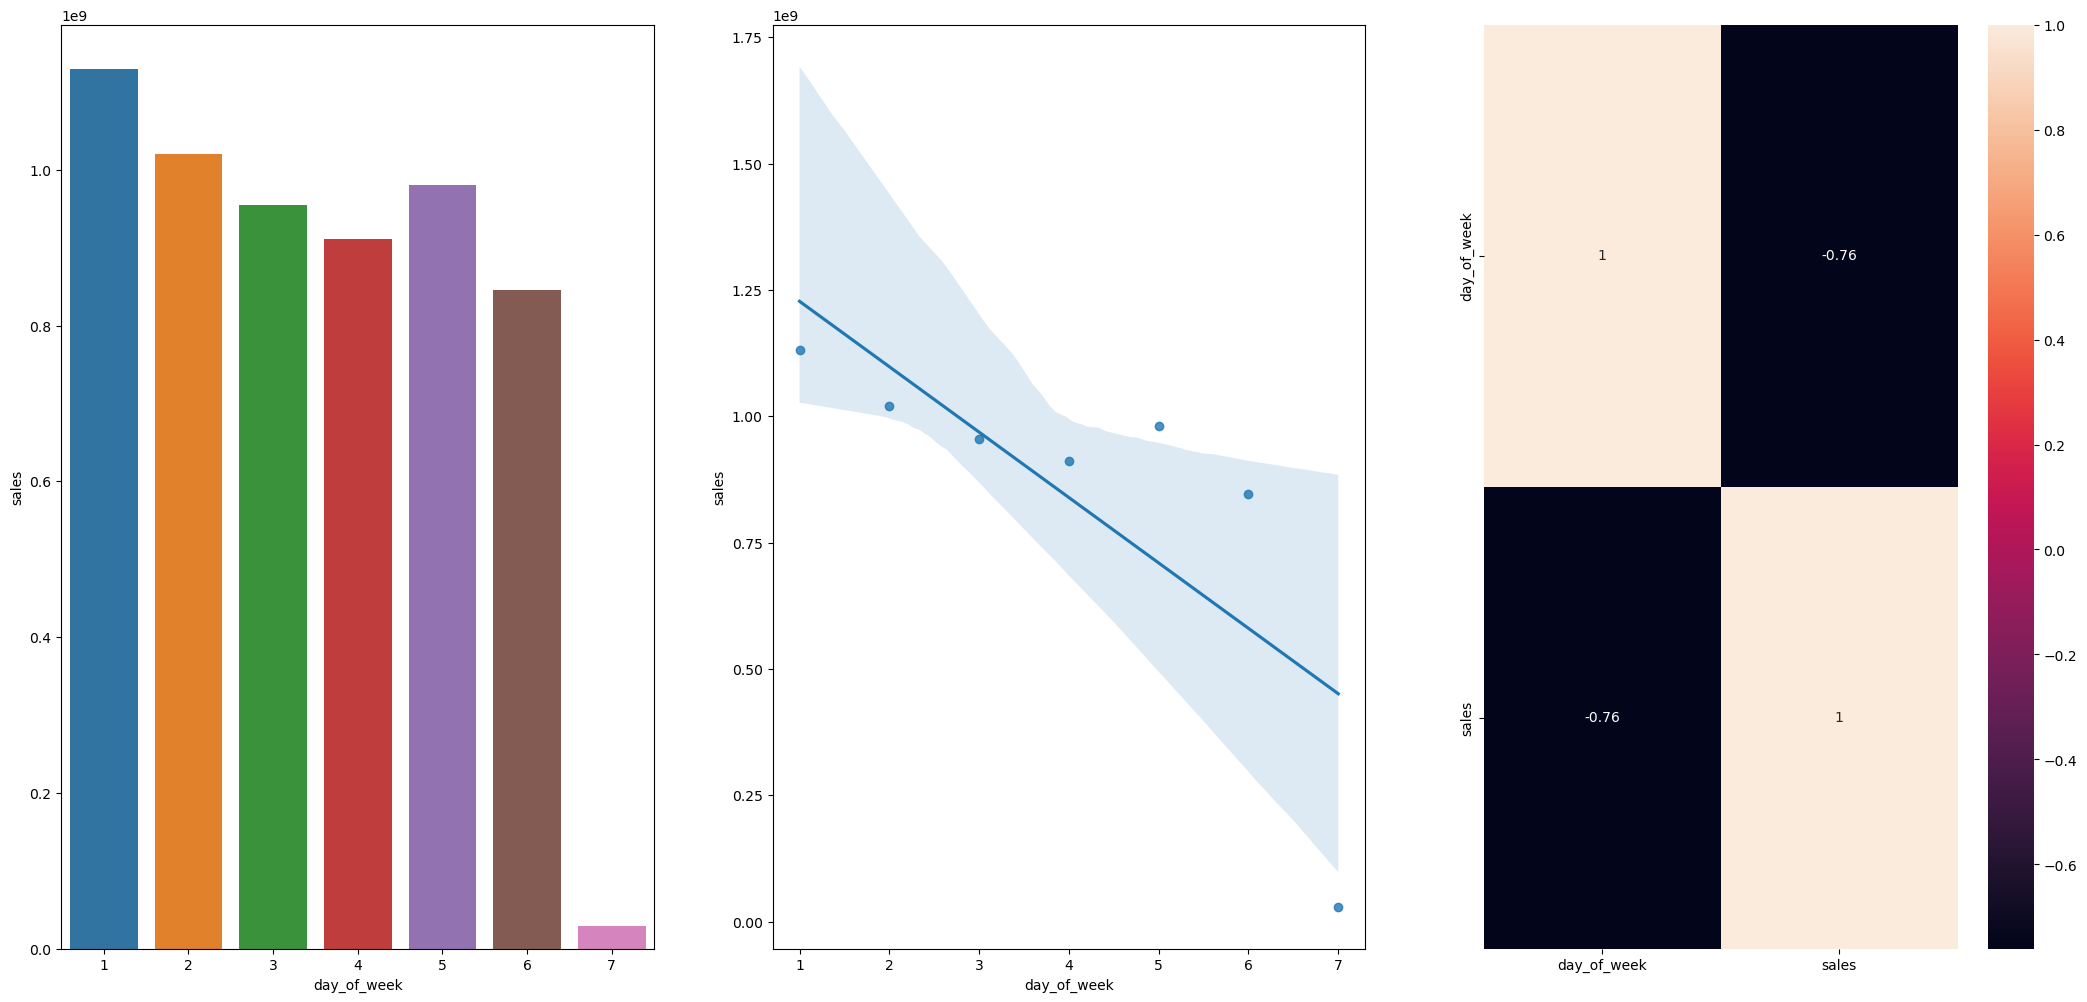

In [42]:
# 4.2.3 ANÁLISE BIVARIADA
# h12. Lojas deveriam vender menos aos finais de semana.
# VERDADEIRA, AS LOJAS VENDEM MENOS AOS FDS

plt.figure(figsize=(26, 12))
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1) # regplot - tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True) # heatmap - correlação


<AxesSubplot:xlabel='month', ylabel='sales'>

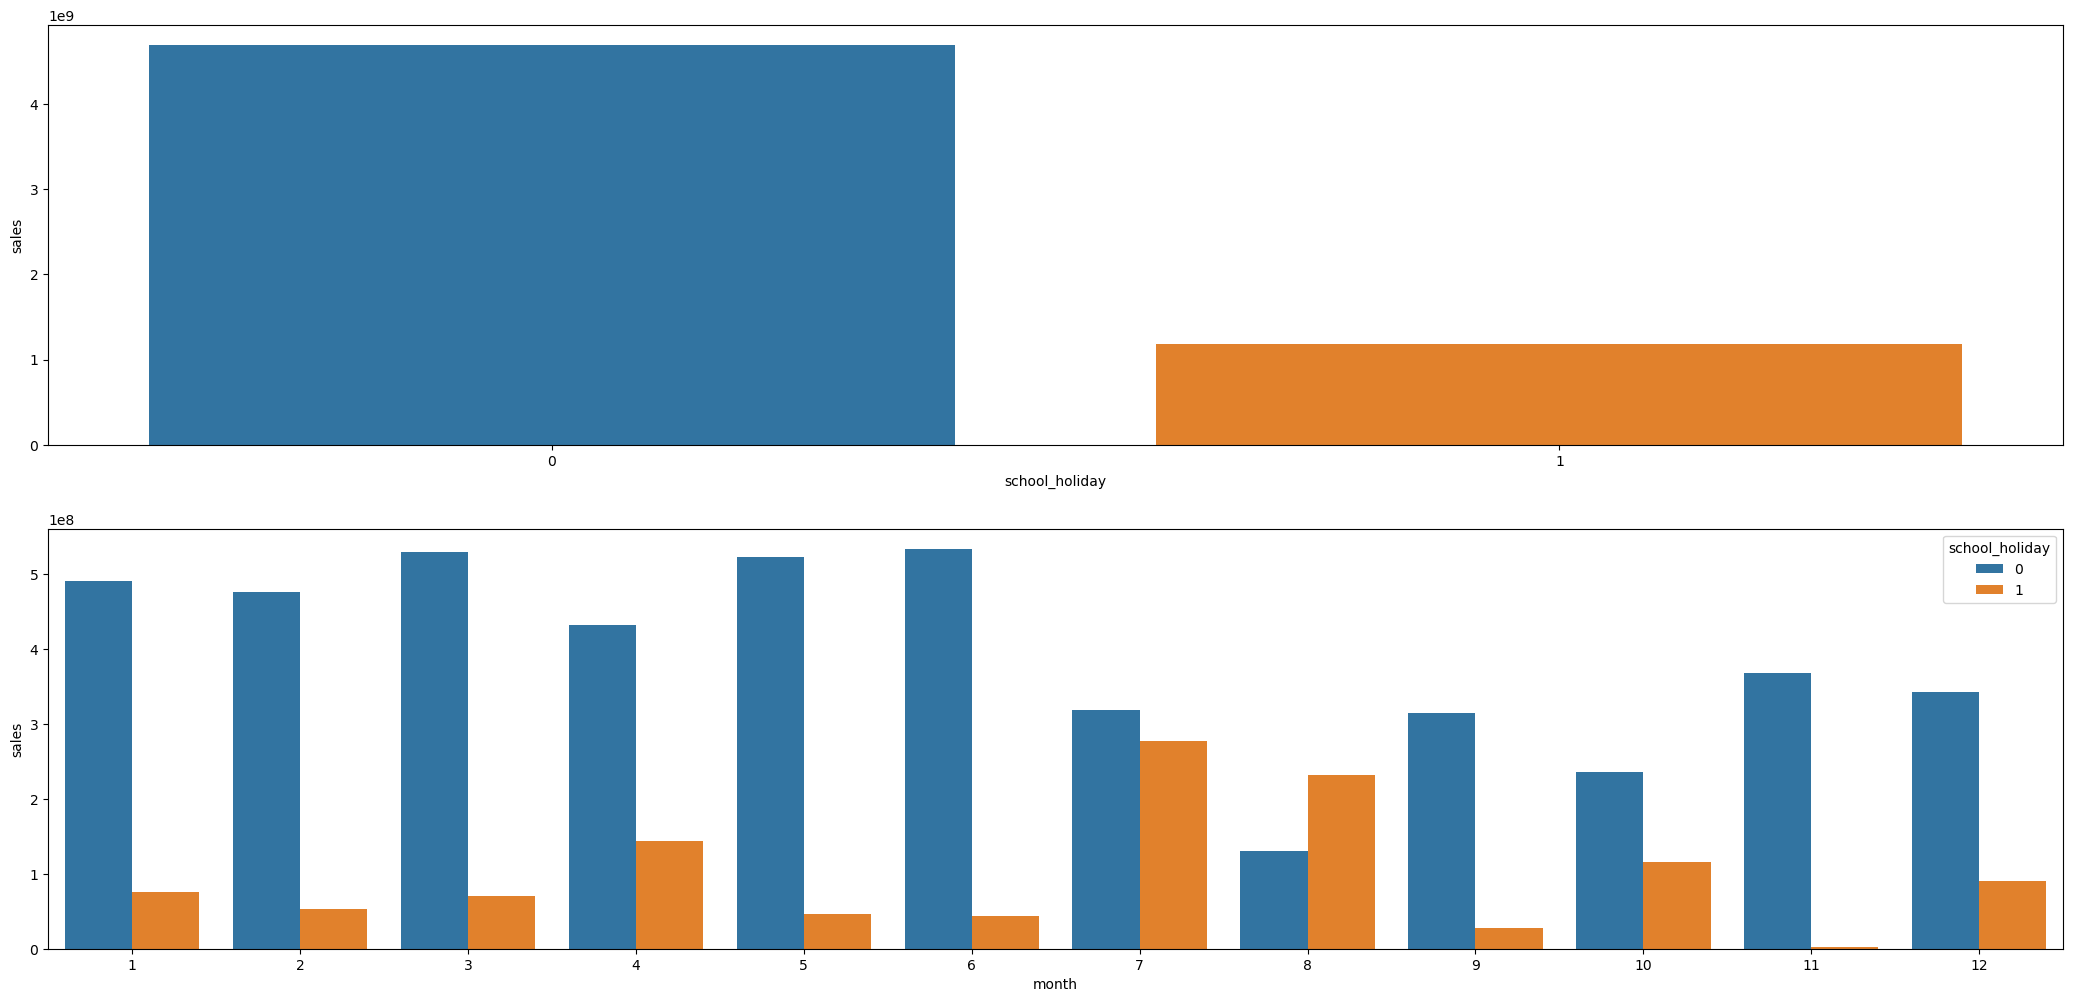

In [43]:
# 4.2.3 ANÁLISE BIVARIADA
# h13. Lojas deveriam vender menos durante os feriados escolares.
# verdadeira, lojas vendem menos nos feriados escolares

plt.figure(figsize=(26, 12))


aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1)


aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2)

In [44]:
# 4.2.4. Resumo das Hipoteses

from tabulate import tabulate
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


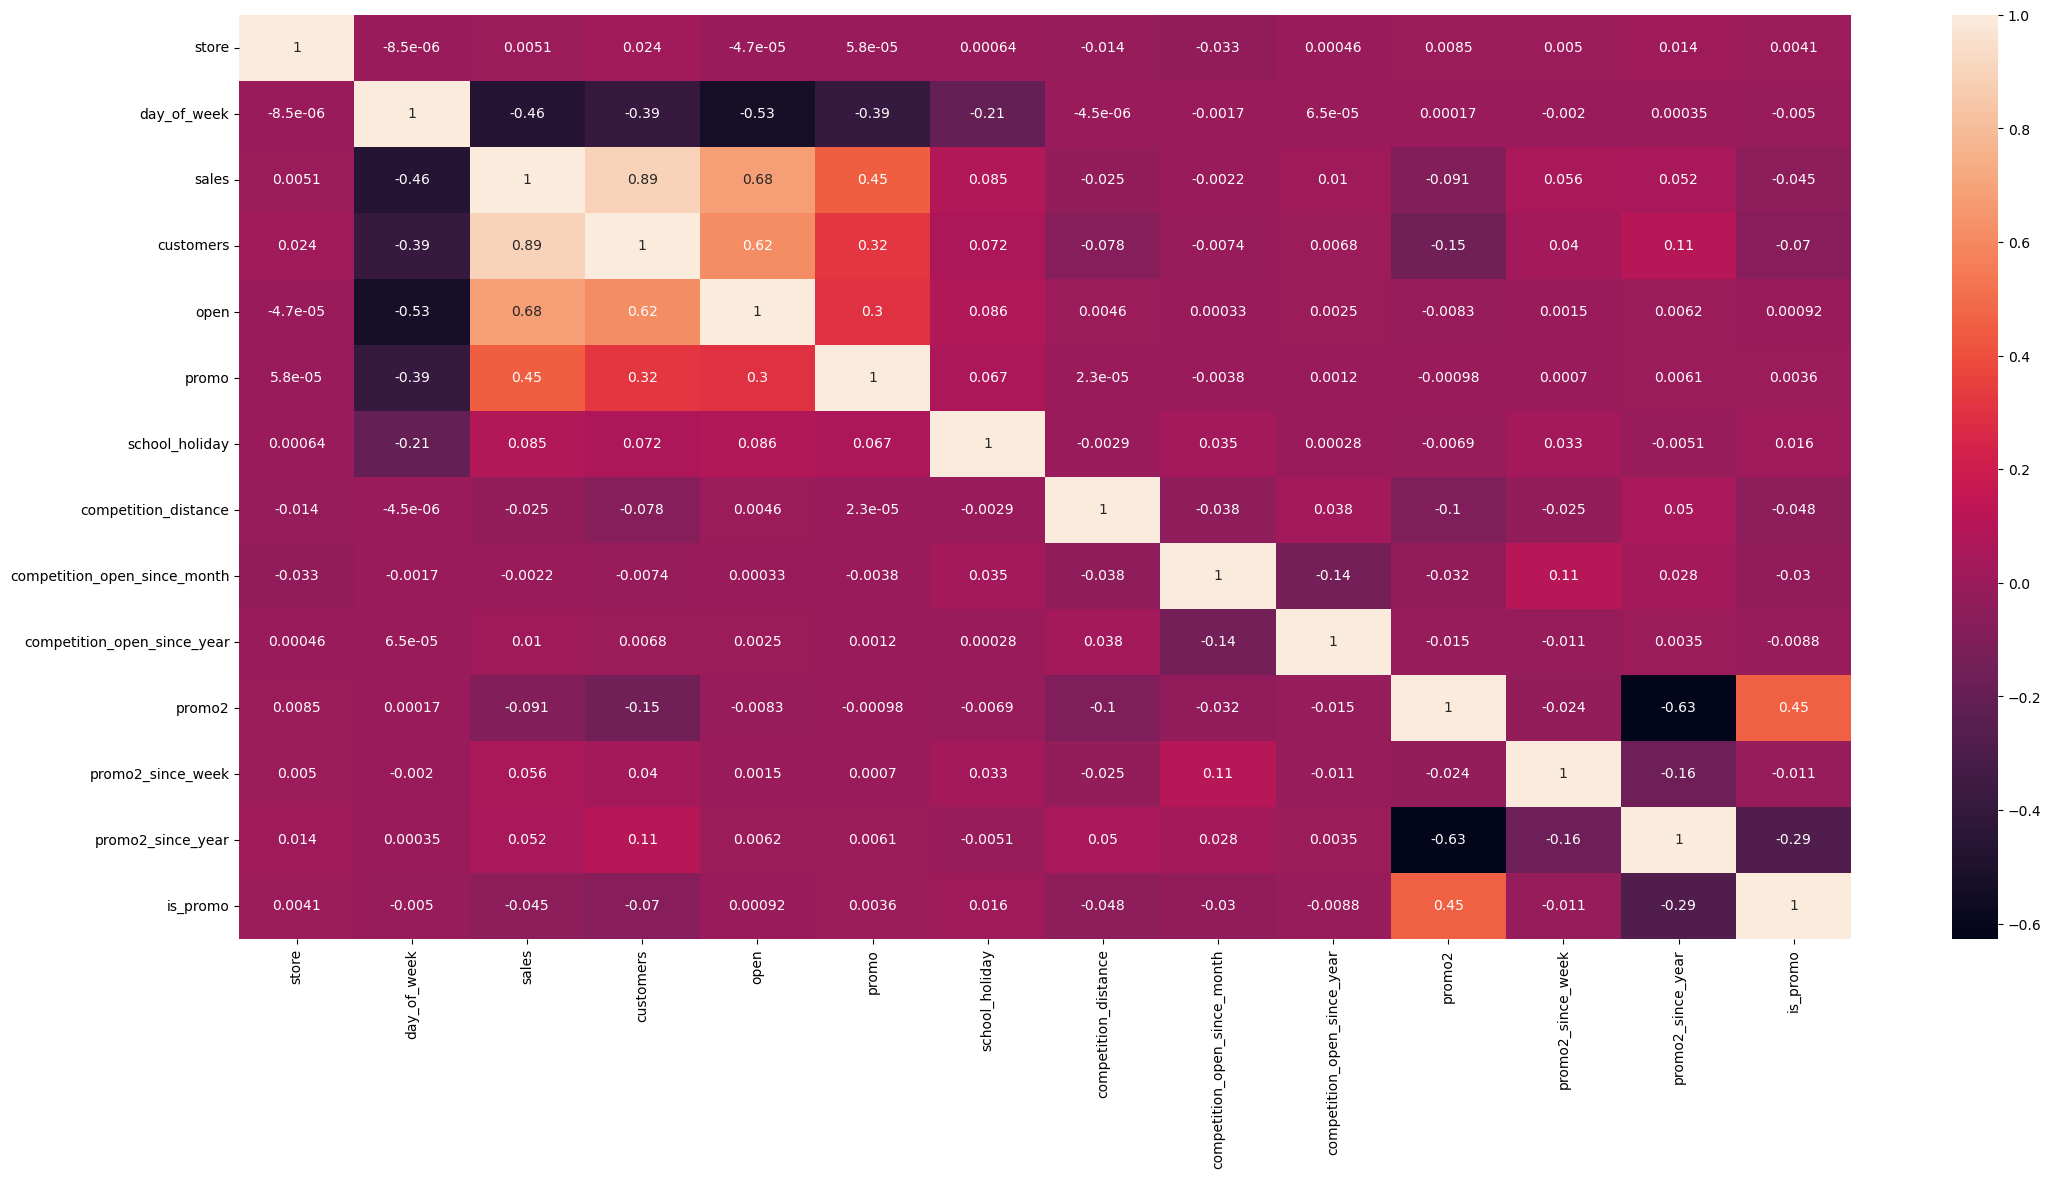

In [45]:
# 4.3 ANÁLISE MULTIVARIADA
### 4.3.1 Numerical Attributes

plt.figure(figsize=(26, 12))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

<AxesSubplot:>

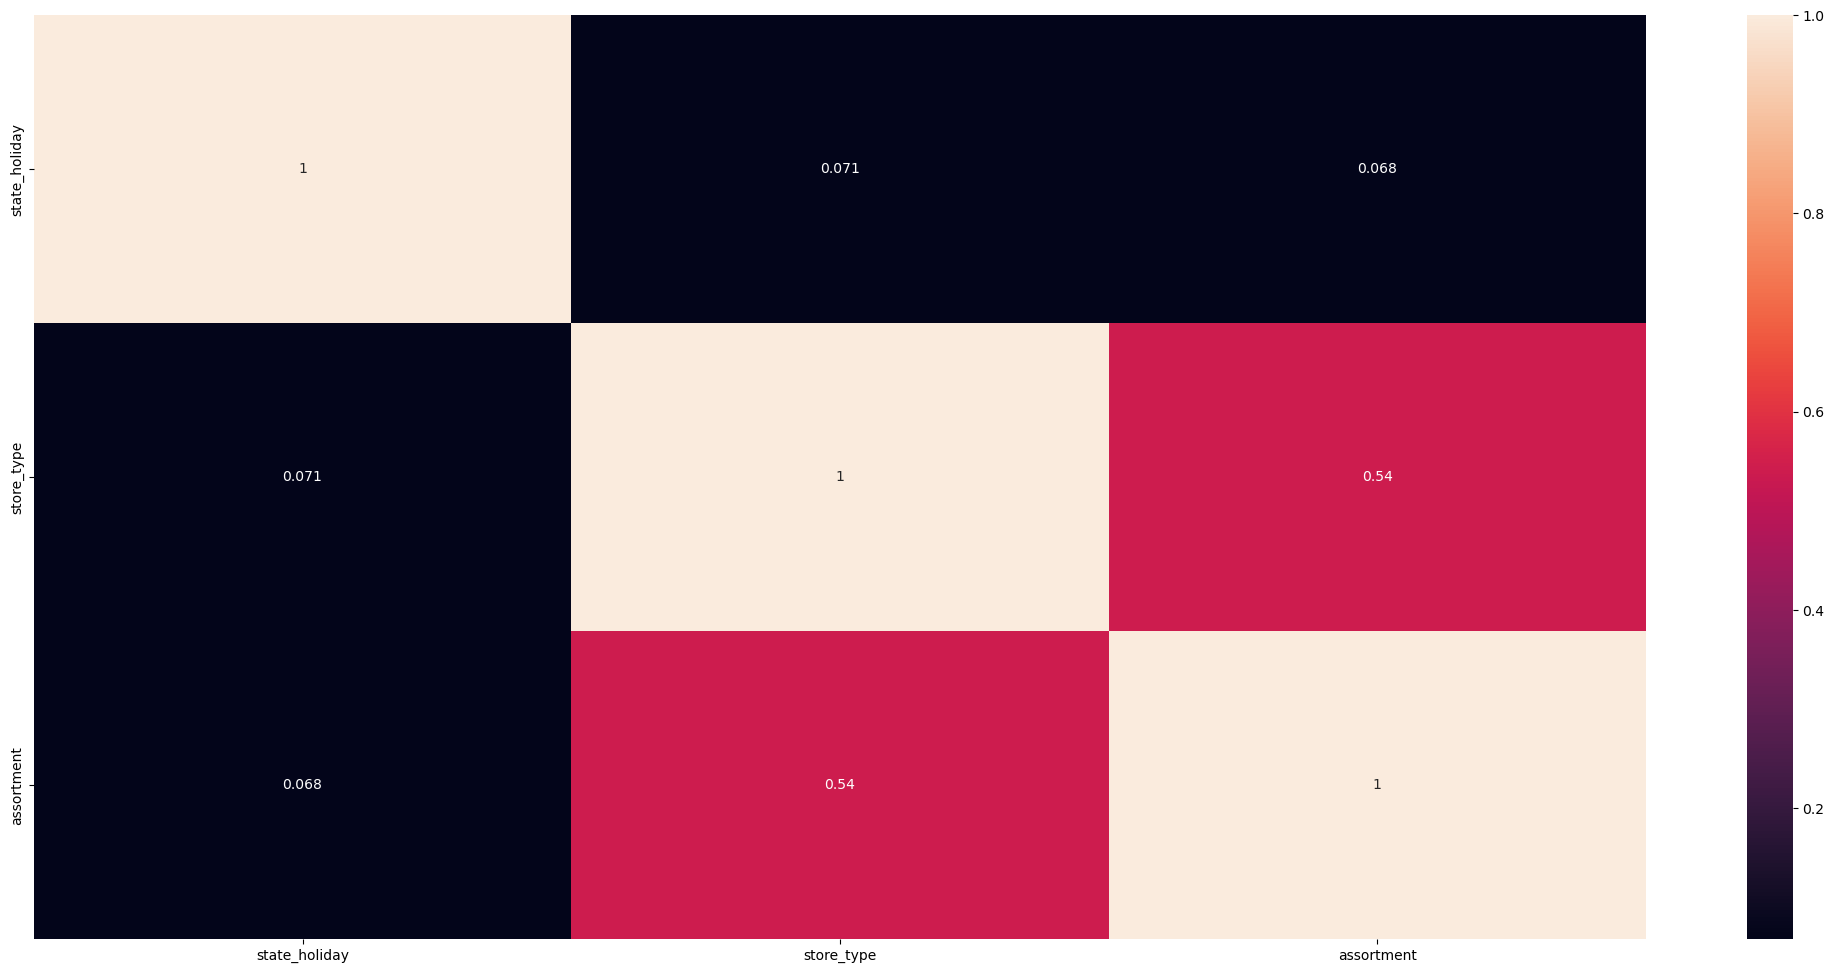

In [46]:
# 4.3 ANÁLISE MULTIVARIADA
### 4.3.1 Categorical Attributes

#Só dados categóricos
a = df4.select_dtypes(include = 'object')

#calculando a função Cramer_v (função definida na sessão "helper functions")
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)
plt.figure(figsize=(26, 12))
sns.heatmap(d,annot=True)

In [47]:
# 5.0 PASSO 05 -  PREPARAÇÃO DE DADOS

df5 = df4.copy()

In [48]:
# 5.1 Normalização

In [49]:
# 5.2 Rescaling

a = df5.select_dtypes(include = ['int64','float64','int32'])

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


In [50]:
# 5.3 Transformação

# month
# day
# week_of_year
# day_of_week

In [51]:
# 5.3.1 Encolding

#state_holiday -  One Hot Encolding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Encolding Label
le =  LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal

assortment_dic =  {'basic':1,'extra':2,'extendend':3}
df5['assortment'] = df5['assortment'].map(assortment_dic)


In [52]:
# 5.3.2 Response Variable Transformation

df5['sales'] = np.log1p(df5['sales'])


In [53]:
# 5.3.2 Nature Transformation

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x:np.sin(x * (np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x:np.cos(x * (np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x:np.sin(x * (np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x:np.cos(x * (np.pi/12)))


# day
df5['day_sin'] = df5['day'].apply(lambda x:np.sin(x * (np.pi/30)))
df5['day__cos'] = df5['day'].apply(lambda x:np.cos(x * (np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x:np.sin(x * (np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x:np.cos(x * (np.pi/52)))



In [54]:
# 6.0 PASSO 06 -  FEATURE SELECTION
df6 = df5.copy()

In [55]:
# 6.1 Split dataframe into training and test

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [56]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)



Timestamp('2015-06-19 00:00:00')

In [57]:
# Training dataset

x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test dataset

x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min date:{}'.format(x_train['date'].min()))
print('Training Max date:{}'.format(x_train['date'].max()))

print('\nTest Min date:{}'.format(x_test['date'].min()))
print('Test Max date:{}'.format(x_test['date'].max()))

Training Min date:2013-01-01 00:00:00
Training Max date:2015-06-18 00:00:00

Test Min date:2015-06-19 00:00:00
Test Max date:2015-07-31 00:00:00


In [58]:
#6.2 Boruta as feature selector

# training and test for Brouta
x_train_n = x_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()


#define RandomDorestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

In [59]:
#6.2.1 Best feature from boruta

#cols_selected = boruta.support_.tolist()

#best featrures
#x_train_fs = x_train.drop(['date','sales'],axix =1 )
#cols_selected_boruta = x_train.iloc[:,cols_selected]

# not seleceted by boruta
#cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

In [60]:
#6.3 Manual feature selection

cols_selected_boruta  = ['store','promo', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day__cos', 'week_of_year_sin',
       'week_of_year_cos']

# columns_to_add
feat_to_add = ['date','sales']

#final featurs

#cols_selected_boruta.extend(feat_to_add)

In [61]:
#7.0 PASSO 7 - MACHINE LEARNING MODELLING

x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]



In [62]:

def ml_error (model_name,y,yhat):
    
    mae = mean_absolute_error (y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error (y, yhat))

    return pd.DataFrame({'Model Name' : model_name,
                          'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index = [0])

In [63]:
#7.1 AVAREGE MODEL

aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


In [66]:
#7.2 LINEAR REGRESSION MODEL

# model

lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#perfomante
lr_result  = ml_error( 'Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))

lr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.126202,0.294635,2661.840827


In [69]:
#7.3 LINEAR REGRESSION REGULARIZED MODEL - Laaso
# model

lrr = Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#perfomante
lrr_result  = ml_error( 'Linear Regression Lasso',np.expm1(y_test),np.expm1(yhat_lrr))

lrr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1897.325175,0.28957,2750.434994
